In [1]:
import re
import os
import cv2
import json
import math
import copy
import torch
import pickle
import random
import denseCRF
import statistics
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import utils.utils as utils
from PIL import Image, ImageOps
from timm.utils import accuracy 
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.manifold import TSNE
from distinctipy import distinctipy
from scipy.stats import gaussian_kde
from sklearn.decomposition import PCA
import matplotlib.patches as mpatches
from torchvision import transforms as T
from engine_self_training import evaluate
from collections import Counter, defaultdict
from utils.build_dataset import build_dataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import SpectralClustering
from utils.model import CLIPClassifier, tokenize
from skimage.measure import label as measure_label
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from torchvision.transforms.functional import InterpolationMode 

/home/muhammad.haris/miniconda3/envs/dassl/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/muhammad.haris/Sathira/Eman_Base/clip/clip.py:23: UserWarning: PyTorch version 1.7.1 or higher is recommended
  warnings.warn("PyTorch version 1.7.1 or higher is recommended")


In [2]:
torch.manual_seed(0)
np.random.seed(0)
torch.set_grad_enabled(False)
torch.cuda.set_device('cuda:3')

In [3]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

In [4]:
args = AttrDict(
    batch_size=64,
    template='templates.json',
    classname='classes.json',
    clip_model='ViT-B/32',
    image_mean=(0.48145466, 0.4578275, 0.40821073),
    image_std=(0.26862954, 0.26130258, 0.27577711),
    input_size=224,
    train_config='configs/train_configs/ours_vit_b_32_cupl_proto.json',
    train_crop_min=0.3,
    color_jitter=0,
    aa='rand-m9-mstd0.5-inc1',
    train_interpolation='bicubic',
    nb_classes=0,
    dataset='fgvc',
    num_workers=10,
    device='cuda',
    resume='output/fgvc/2025-05-13_07:35:25_ViT-B_32_TokenFusion_DINO_removed_gamma_0.8_8crops_epoch15_lr0.0001/checkpoint-last.pth',
    vis=True,
    use_gpt3_prompts=True,
    text_finetune_only=False,
    text_descriptions_path='all_prompts/train_prompts/',
    ctx_checkpoint=None,
    alpha=0.5,
    beta=0.9,
    n_samples=16,
    n_crops=8,
    eval=False,
    baseline=False,
    use_crops_for_test=False,
    text_scale=1.0,
    use_naive_token_avg=False,
    use_global_feature_for_query=False,
    use_unr_token=False
)

In [5]:
train_config_path = args.train_config
with open(train_config_path, 'r') as train_config_file:
    train_config = json.load(train_config_file)
dataset_config_path = os.path.join("configs/dataset_configs/", args.dataset + ".json")
with open(dataset_config_path, 'r') as dataset_config_file:
    dataset_params = json.load(dataset_config_file)
device = torch.device(args.device)
args.train_config = train_config
args.dataset_params = dataset_params

In [6]:
batch_size = args.batch_size

In [7]:
dataset_train, len_original = build_dataset(is_train=True, args=args)
sampler_train = torch.utils.data.RandomSampler(dataset_train)
data_loader_train = torch.utils.data.DataLoader(
    dataset_train, 
    sampler     = sampler_train,
    batch_size  = batch_size,
    num_workers = 2,
    pin_memory  = True,
    drop_last   = False,
)

In [8]:
dataset_val, _ = build_dataset(is_train=False, args=args)  
sampler_val = torch.utils.data.SequentialSampler(dataset_val)
data_loader_val = torch.utils.data.DataLoader(
    dataset_val, 
    sampler     = sampler_val,
    batch_size  = 4 * batch_size,
    num_workers = 2,
    pin_memory  = True,
    drop_last   = False
)

In [9]:
model = CLIPClassifier(args)
args.nb_classes = len(model.classnames)
checkpoint = torch.load(args.resume, map_location='cpu')
model.load_state_dict(checkpoint['model'], strict=False)

Embedding dimension: 512
Number of classes: 100
Using ensembled handcrafted prompts for zero-shot class embeddings.


Loading GPT3 prompts: 100%|██████████| 100/100 [00:02<00:00, 35.83it/s]


Using CuPL textual prototypes as classifier.


_IncompatibleKeys(missing_keys=['clip_model.positional_embedding', 'clip_model.text_projection', 'clip_model.logit_scale', 'clip_model.transformer.resblocks.0.attn.in_proj_weight', 'clip_model.transformer.resblocks.0.attn.in_proj_bias', 'clip_model.transformer.resblocks.0.attn.out_proj.weight', 'clip_model.transformer.resblocks.0.attn.out_proj.bias', 'clip_model.transformer.resblocks.0.ln_1.weight', 'clip_model.transformer.resblocks.0.ln_1.bias', 'clip_model.transformer.resblocks.0.mlp.c_fc.weight', 'clip_model.transformer.resblocks.0.mlp.c_fc.bias', 'clip_model.transformer.resblocks.0.mlp.c_proj.weight', 'clip_model.transformer.resblocks.0.mlp.c_proj.bias', 'clip_model.transformer.resblocks.0.ln_2.weight', 'clip_model.transformer.resblocks.0.ln_2.bias', 'clip_model.transformer.resblocks.1.attn.in_proj_weight', 'clip_model.transformer.resblocks.1.attn.in_proj_bias', 'clip_model.transformer.resblocks.1.attn.out_proj.weight', 'clip_model.transformer.resblocks.1.attn.out_proj.bias', 'clip

In [10]:
classnames = model.classnames

In [11]:
'Total LLM generated texts:', sum([len(txt) for txt in model.all_texts])

('Total LLM generated texts:', 2000)

In [12]:
def get_norm_tfm(args):
    return T.Normalize(
                mean=torch.tensor(args.image_mean),
                std=torch.tensor(args.image_std))

## Normalized Cut

In [13]:
def get_foreground_mask_ncut(patch_keys, grid_size, tau=0.2, eps=1e-6):
    A = torch.matmul(patch_keys, patch_keys.transpose(1, 2))
    A = (A > tau).float()  # Convert to binary adjacency matrix
    A = torch.where(A == 0, torch.full_like(A, eps), A)  # Replace 0s with eps
    # Compute Degree Matrix D (B, num_patches, num_patches)
    D = torch.diag_embed(torch.sum(A, dim=2))
    
    # Compute normalized Laplacian L_sym = D⁻¹/² * (D - A) * D⁻¹/²
    D_inv_sqrt = torch.diag_embed(1.0 / (torch.sqrt(torch.sum(A, dim=2)) + eps))
    L_sym = torch.matmul(torch.matmul(D_inv_sqrt, (D - A)), D_inv_sqrt)
    # Solve eigenproblem: L_sym * x = λ * x
    _, eigenvectors = torch.linalg.eigh(L_sym)  # Output shape: (B, num_patches, num_patches)
    
    fiedler_vector = eigenvectors[:, :, 1]
    # Compute bipartition threshold based on mean value
    avg = fiedler_vector.std(dim=1, keepdim=True)
    bipartition = fiedler_vector > avg  # Boolean mask, shape: (B, num_patches)
    
    # Find the seed (index of max absolute value in eigenvector)
    seed_indices = torch.argmax(torch.abs(fiedler_vector), dim=1)  # Shape: (B,)

    # Ensure consistent sign across batch
    for i in range(patch_keys.size(0)):
        if bipartition[i, seed_indices[i]] != 1:
            fiedler_vector[i] *= -1
            bipartition[i] = ~bipartition[i]  # Logical NOT for batch item i

    # Reshape to (B, grid_size, grid_size)
    bipartition = bipartition.view(-1, grid_size, grid_size)
    
    return bipartition, fiedler_vector

In [14]:
def get_label_colors():
    # base colors
    label_colors = {
            0: [255, 0, 0], 
            1: [0, 255, 0],     
            2: [0, 0, 255],     
            3: [255, 255, 0],   
            4: [255, 165, 0],
            5: [255, 192, 203],
            6: [160, 32, 240],
            7: [0, 255, 255], 
            8: [128, 0, 0],
            9: [128, 128, 0],
            10: [128, 0, 128],
            11: [255, 105, 180],
            12: [75, 0, 130],
            13: [0, 128, 0],
            14: [0, 128, 128],
            15: [70, 130, 180],
            16: [255, 69, 0],
            17: [139, 69, 19],
            18: [0, 0, 128], 
            19: [255, 20, 147], 
            20: [255, 140, 0]}
    
    # add 30 other random colors
#     start_from = list(label_colors.keys())[-1] + 1
#     for c in range(start_from, 100):
#         label_colors[c] = [random.randint(0,255), random.randint(0,255), random.randint(0,255)]
    
    return label_colors

In [15]:
def compute_attn_pooled_features(model, query, patch_feats, mask=None):
    local_feats = patch_feats
    if mask is not None:
        local_feats = local_feats * mask.unsqueeze(-1)  # (B, N, D)
    # Append empty token
    local_feats = torch.cat([local_feats, torch.zeros(local_feats.size(0), 1, local_feats.size(-1)).to(local_feats.device)], dim=1)  # (B, N+1, D)
    # Compute attention weights
    attn_weights = torch.softmax(model.query_proj(query).unsqueeze(1) @ model.key_proj(local_feats).permute(0, 2, 1) / math.sqrt(patch_feats.size(-1)), dim=-1)
    attn_weights = attn_weights.squeeze(1)
    # Attention pool the local features
    local_feat = torch.sum(model.value_proj(local_feats) * attn_weights.unsqueeze(-1), dim=1)
    composite_feat = F.normalize(local_feat @ model.clip_model.visual.proj, p=2, dim=-1)
    return attn_weights, composite_feat

In [16]:
def get_local_global_features(args, img, model, dino, visualize=False, normalize=False, iter_name=''):
    norm_tfm = get_norm_tfm(args)
    
    if normalize:
        img_normalized = norm_tfm(img)
    else:
        img_normalized = img
    global_feat, local_feat, global_cls_token = model(img_normalized, return_patch_tokens=True, return_cls_token=True)

    _, _, key_feats = model.extract_last_layer_key_feats(img_normalized)
    model.clear_layer_activations()
    key_feats = F.normalize(key_feats[:, 1:], p=2, dim=-1)

    grid_size = int(np.sqrt(local_feat.size(1)))
    fg_mask, fiedler_vector = get_foreground_mask_ncut(key_feats, grid_size)
            
    if args.use_naive_token_avg: # No Attention Pooling
        local_pooled_feats = local_feat.mean(dim=1)
        pooled_local_feats = F.normalize(local_pooled_feats @ model.clip_model.visual.proj, p=2, dim=-1)
        attn_weights = None
    else:
        if args.use_global_feature_for_query: # No Normalized Cut
            query_feats = global_cls_token
        else: # Use Normalized Cut
            masked_feat = (local_feat) * fg_mask.flatten(1, 2).unsqueeze(-1)  # (B, N, D)
            mask_sum = fg_mask.flatten(1, 2).sum(dim=1, keepdim=True).clamp(min=1)  # (B, 1)
            query_feats = masked_feat.sum(dim=1) / mask_sum  # (B, D)
        
        # Attention pool the local features
        attn_weights, pooled_local_feats = compute_attn_pooled_features(model, query_feats, local_feat)
    
    if visualize: # Visualize Normalized Cut
        upscaled_mask = fg_mask[0].cpu().numpy().astype(np.float32)
        upscaled_mask = cv2.resize(upscaled_mask, dsize=(args.input_size, args.input_size), interpolation=cv2.INTER_NEAREST)
        img = (img[0].cpu().numpy().transpose(1, 2, 0) * 255).astype(np.uint8)
        unary_potentials = torch.from_numpy(upscaled_mask).long()
        unary_potentials = F.one_hot(unary_potentials.long(), num_classes=2).float().numpy()
        out = denseCRF.densecrf(img, unary_potentials, (10, 40, 13, 3, 3, 5.0))
        seg_mask = np.zeros((out.shape[0], out.shape[1], 3), dtype=np.uint8)
        for label, color in get_label_colors().items():
            seg_mask[out == label] = color
            seg_mask[out == 0] = 0
            if label == out.max():
                break
        seg_mask = cv2.resize(seg_mask, dsize=(args.input_size, args.input_size), interpolation=cv2.INTER_NEAREST)   
        result = cv2.addWeighted(img, 0.5, seg_mask, 0.5, 0)
        plt.figure(figsize=(8, 6))
        plt.imshow(result)
        plt.tight_layout()
        plt.axis('off')
        plt.savefig(f'NCut_{iter_name}.png', bbox_inches='tight', dpi=300)
    
    return global_feat, pooled_local_feats, attn_weights

In [ ]:
tfm1 = T.Compose([
    T.Resize(args.input_size, interpolation=InterpolationMode.BICUBIC),
    T.RandomCrop(args.input_size),
])
tfm2 = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=torch.tensor(args.image_mean), std=torch.tensor(args.image_std))
])

# Load samples from dataset
try:
    samples = dataset_val.samples
except AttributeError:
    samples = dataset_val.data

# Organize images by class
from collections import defaultdict
class_to_images = defaultdict(list)
for path, label in samples:
    class_to_images[label].append(path)
    
# Randomly select 20 categories
selected_classes = random.sample(class_to_images.keys(), 20)

# Prepare the image grid
num_rows = 10
num_cols = 20
fig = plt.figure(figsize=(20, 10))  # Control output size
fig.patch.set_visible(False)

# Each image box size (normalized)
w, h = 1.0 / num_cols, 1.0 / num_rows

for col_idx, class_id in enumerate(selected_classes):
    images = random.sample(class_to_images[class_id], num_rows)
    
    for row_idx, img_path in enumerate(images):
        img = Image.open(img_path).convert("RGB")
        img = tfm1(img)
        img_np = np.array(img)
        
        # Calculate exact position
        left = col_idx * w
        bottom = 1.0 - (row_idx + 1) * h
        ax = fig.add_axes([left, bottom, w, h])
        ax.imshow(img_np)
        ax.axis("off")

plt.savefig("Flowers_collage.png", dpi=300, bbox_inches='tight', pad_inches=0)

Ground Truth: Gulfstream IV
Local Predictions: Gulfstream V
Global Predictions: Gulfstream IV
Average Predictions: Gulfstream V 0.5427921414375305


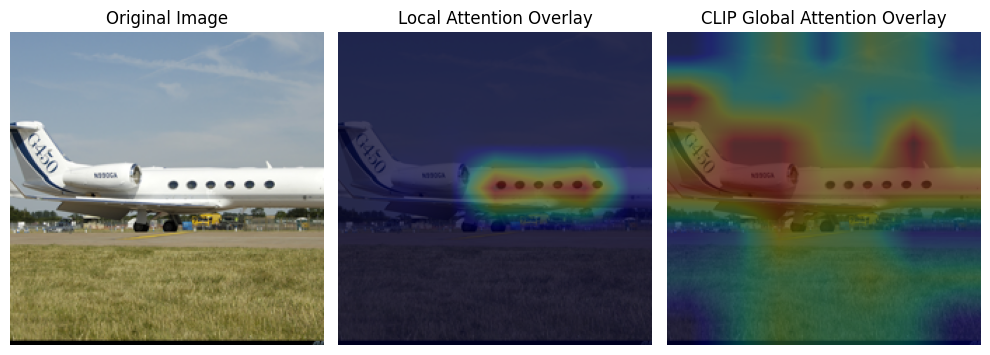

In [37]:
tfm1 = T.Compose([
    T.Resize(args.input_size, interpolation=InterpolationMode.BICUBIC),
    T.RandomCrop(args.input_size),
])
tfm2 = T.Compose([
    T.ToTensor(),
    T.Normalize(
        mean=torch.tensor(args.image_mean),
        std=torch.tensor(args.image_std))
])

rand_id = np.random.randint(len(dataset_val))
# Fix the following when you need to test a specific image!!
rand_id = 2676
try:
    dataloader_returns = dataset_val.samples[rand_id]
except:
    dataloader_returns = dataset_val.data[rand_id]
img_path, gt_label = dataloader_returns
# while classnames[gt_label] != 'Gulfstream IV':
#     old_rand_id = rand_id
#     try:
#         dataloader_returns = dataset_val.samples[rand_id]
#     except:
#         dataloader_returns = dataset_val.data[rand_id]
#     img_path, gt_label = dataloader_returns
#     rand_id = np.random.randint(len(dataset_val))
# print('Random ID:', old_rand_id)
    
img_path, gt_label = dataloader_returns
img_orig = Image.open(img_path).convert('RGB')
img = tfm1(img_orig)
img_train_weak = tfm2(img).unsqueeze(0).cuda()
global_feat, local_feat, cls_token = model(img_train_weak, return_patch_tokens=True, return_cls_token=True)

# patch_feats = dino.get_intermediate_layers(img_train_weak, n=2)[0]
# dino_feats = patch_feats[:, 1]
# patch_feats = patch_feats[:, 1:]
# patch_feats = patch_feats.view(patch_feats.size(0), 14, 14, patch_feats.size(-1)).permute(0, 3, 1, 2)
# patch_feats = patch_feats.flatten(2).transpose(1, 2)
# grid_size = int(np.sqrt(patch_feats.size(1)))
# fg_mask, fiedler_vector = get_foreground_mask_ncut(patch_feats, grid_size)

# masked_feat = patch_feats * fg_mask.flatten(1, 2).unsqueeze(-1)  # (B, N, D)
# mask_sum = fg_mask.flatten(1, 2).sum(dim=1, keepdim=True).clamp(min=1)  # (B, 1)
# query_feats = masked_feat.sum(dim=1) / mask_sum  # (B, D)

grid_size = int(np.sqrt(local_feat.size(1)))
fg_mask, fiedler_vector = get_foreground_mask_ncut(local_feat, grid_size)
masked_feat = local_feat * fg_mask.flatten(1, 2).unsqueeze(-1)  # (B, N, D)
mask_sum = fg_mask.flatten(1, 2).sum(dim=1, keepdim=True).clamp(min=1)  # (B, 1)
query_feats = masked_feat.sum(dim=1) / mask_sum  # (B, D)

# Compute attention weights
attn_weights = torch.softmax(model.query_proj(query_feats).unsqueeze(1) @ model.key_proj(local_feat).permute(0, 2, 1) / math.sqrt(local_feat.size(-1)), dim=-1)
attn_weights = attn_weights.squeeze(1)

pooled_local_feats = torch.sum(model.value_proj(local_feat) * attn_weights.unsqueeze(-1), dim=1)
pooled_local_feats = F.normalize(pooled_local_feats @ model.clip_model.visual.proj, p=2, dim=-1)

attn_weights = (attn_weights - attn_weights.min(dim=1, keepdim=True)[0]) / (attn_weights.max(dim=1, keepdim=True)[0] - attn_weights.min(dim=1, keepdim=True)[0] + 1e-6)

upscaled_attn_weights = F.interpolate(attn_weights.reshape(7, 7).unsqueeze(0).unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False)
upscaled_attn_weights = upscaled_attn_weights.squeeze(0).squeeze(0).cpu().numpy()

upscaled_mask = fg_mask[0].cpu().numpy().astype(np.float32)
upscaled_mask = cv2.resize(upscaled_mask, dsize=(args.input_size, args.input_size), interpolation=cv2.INTER_NEAREST)
unary_potentials = torch.from_numpy(upscaled_mask)
unary_potentials = F.one_hot(unary_potentials.long(), num_classes=2).float().numpy()
out = denseCRF.densecrf(img, unary_potentials, (10, 40, 13, 3, 3, 5.0))
seg_mask = np.zeros((out.shape[0], out.shape[1], 3), dtype=np.uint8)
for label, color in get_label_colors().items():
    seg_mask[out == label] = color
    seg_mask[out == 0] = 0
    if label == out.max():
        break
seg_mask = cv2.resize(seg_mask, dsize=(args.input_size, args.input_size), interpolation=cv2.INTER_NEAREST)   
image = (T.ToTensor()(img).cpu().numpy().transpose(1, 2, 0) * 255).astype(np.uint8)
result = cv2.addWeighted(image, 0.5, seg_mask, 0.5, 0)

CLIP_attn = F.normalize(local_feat, p=2, dim=-1) @ F.normalize(cls_token, p=2, dim=-1).t()
CLIP_attn = (CLIP_attn - CLIP_attn.min(dim=1, keepdim=True)[0]) / (CLIP_attn.max(dim=1, keepdim=True)[0] - CLIP_attn.min(dim=1, keepdim=True)[0] + 1e-6)
CLIP_attn = F.interpolate(CLIP_attn.reshape(7, 7).unsqueeze(0).unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False)
CLIP_attn = CLIP_attn.squeeze(0).squeeze(0).cpu().numpy()

overlaid_img = (0.5 * T.ToTensor()(img).permute(1, 2, 0).numpy() + 0.5 * plt.cm.jet(upscaled_attn_weights)[..., :3]) / 2
image_np = (T.ToTensor()(img).permute(1, 2, 0).numpy() * 255).astype(np.uint8)
# overlaid_img = image_np.copy()
patch_h, patch_w = args.input_size // 7, args.input_size // 7
attn_map = attn_weights.reshape(7, 7).cpu().numpy()
attn_map = (attn_map - attn_map.min()) / (attn_map.max() - attn_map.min() + 1e-6)

# for i in range(7):
#     for j in range(7):
#         alpha = attn_map[i, j]
#         if alpha < 0.05:
#             continue
#         overlay_color = np.array([255, 0, 0], dtype=np.uint8)  # red
#         y1, y2 = i * patch_h, (i + 1) * patch_h
#         x1, x2 = j * patch_w, (j + 1) * patch_w
#         overlaid_img[y1:y2, x1:x2] = (
#             alpha * overlay_color + (1 - alpha) * overlaid_img[y1:y2, x1:x2]
#         ).astype(np.uint8)

CLIP_attn_overlaid_img = (0.5 * T.ToTensor()(img).permute(1, 2, 0).numpy() + 0.5 * plt.cm.jet(CLIP_attn)[..., :3]) / 2
# CLIP_attn_map = CLIP_attn.reshape(7, 7)
# clip_attn_img = image_np.copy()
# CLIP_attn_map = (CLIP_attn_map - CLIP_attn_map.min()) / (CLIP_attn_map.max() - CLIP_attn_map.min() + 1e-6)

# for i in range(7):
#     for j in range(7):
#         alpha = CLIP_attn_map[i, j]
#         if alpha < 0.05:
#             continue
#         overlay_color = np.array([255, 0, 0], dtype=np.uint8)  # red
#         y1, y2 = i * patch_h, (i + 1) * patch_h
#         x1, x2 = j * patch_w, (j + 1) * patch_w
#         clip_attn_img[y1:y2, x1:x2] = (
#             alpha * overlay_color + (1 - alpha) * clip_attn_img[y1:y2, x1:x2]
#         ).astype(np.uint8)

# CLIP_attn_overlaid_img = clip_attn_img

local_logits = pooled_local_feats @ model.get_classifier().t()
local_preds = torch.argmax(local_logits, dim=1)
global_logits = global_feat @ model.get_classifier().t()
global_preds = torch.argmax(global_logits, dim=1)
avg_logits = (local_logits + global_logits) / 2
avg_preds = torch.argmax(avg_logits, dim=1)

conf = torch.softmax(100 * avg_logits, dim=1).max(dim=1)[0].item()
print('Ground Truth:', classnames[gt_label])
print('Local Predictions:', classnames[local_preds.item()])
print('Global Predictions:', classnames[global_preds.item()])
print('Average Predictions:', classnames[avg_preds.item()], conf)

# ==== Comment out the following lines when you decied on one image only. Otherwise it'll save multiple images to the disk ====
# fig = plt.figure(figsize=(5, 5))
# plt.imshow(img)
# plt.tight_layout()
# plt.axis('off')
# plt.savefig(f'image_{args.dataset}_{rand_id}.png', bbox_inches='tight', dpi=300)
# plt.close(fig)

fig = plt.figure(figsize=(5, 5))
plt.imshow(overlaid_img)
plt.axis('off')
plt.tight_layout()
plt.savefig(f'local_attn_{args.dataset}_{rand_id}.png')
plt.close(fig)

# fig = plt.figure(figsize=(5, 5))
# plt.imshow(CLIP_attn_overlaid_img)
# plt.axis('off')
# plt.tight_layout()
# plt.savefig(f'CLIP_attn_{args.dataset}_{rand_id}.png')
# plt.close(fig)

fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(img)
ax[0].set_title('Original Image')
ax[0].axis('off')
ax[1].imshow(overlaid_img)
ax[1].set_title('Local Attention Overlay')
ax[1].axis('off')
ax[2].imshow(CLIP_attn_overlaid_img)
ax[2].set_title('CLIP Global Attention Overlay')
ax[2].axis('off')
plt.tight_layout()

# t-SNE Visualizations

In [76]:
def prepare_embeddings(img_embeddings, txt_embeddings):
    U, s, V = torch.svd(txt_embeddings.t().to(torch.float32))
    txt_proj = U[:, 1:] @ U[:, 1:].t()
    # Remove class-agnostic information from visual embeddings.
    img_embeddings = F.normalize(img_embeddings @ txt_proj, dim=-1)
    # Remove redundant information from text embeddings.
    txt_embeddings = F.normalize(txt_embeddings @ txt_proj, dim=-1)
    return img_embeddings, txt_embeddings

In [77]:
def visualize_clip_embeddings(image_embeddings=None, 
                              text_embeddings=None, 
                              image_prototypes=None, 
                              text_prototypes=None, 
                              classnames=None, 
                              gt_classes=None, 
                              orig_images=None,
                              random_seed=42, 
                              perplexity=30, 
                              n_iter=1000,
                              save_path=None,
                              figsize=(12, 12),
                              legend=True,
                              color_list=None,
                              filter_classes=None):
    """
    Visualize CLIP embeddings using t-SNE and Seaborn.

    Args:
        image_embeddings (np.array): Image embeddings of shape (num_images, embed_dim).
        text_embeddings (np.array): Text embeddings of shape (num_texts, embed_dim).
        image_prototypes (np.array): Image prototypes of shape (num_classes, embed_dim).
        text_prototypes (np.array): Text prototypes of shape (num_classes, embed_dim).
        classnames (list): List of class names for the embeddings. Optional.
        gt_classes (np.array): Ground-truth class labels for image and/or text embeddings. Optional.
        random_seed (int): Random seed for t-SNE. Default is 42.
        perplexity (int): Perplexity parameter for t-SNE. Default is 30.
        n_iter (int): Number of iterations for t-SNE optimization. Default is 1000.

    Returns:
        None. Displays the t-SNE plot.
    """
    embeddings = []
    labels = []
    types = []  # To distinguish between image, text, and prototypes
    class_order = []  # To maintain order of classes for color assignment

    if gt_classes is not None and filter_classes is not None:
        gt_classes = [x for x, y in zip(gt_classes, color_list) if classnames[y] in filter_classes]
    
    # Check for available embeddings and add them to a single list
    if image_embeddings is not None:
        mask = np.ones(len(image_embeddings), dtype=bool)
        if filter_classes is not None:
            mask = np.array([classnames[x] in filter_classes for x in color_list])
            image_embeddings = image_embeddings[mask]
        embeddings.append(image_embeddings)
        labels.extend(gt_classes if gt_classes is not None else [-1] * len(image_embeddings))
        types.extend(['Image Embeddings'] * len(image_embeddings))
        class_order.extend(gt_classes if gt_classes is not None else [])

    if text_embeddings is not None:
        embeddings.append(text_embeddings)
        labels.extend(gt_classes if gt_classes is not None else [-1] * len(text_embeddings))
        types.extend(['Text Embeddings'] * len(text_embeddings))
        class_order.extend(gt_classes if gt_classes is not None else [])

    if image_prototypes is not None:
        embeddings.append(image_prototypes)
        labels.extend(list(range(len(image_prototypes))))  # Assuming prototypes are arranged as class order
        types.extend(['Image Prototypes'] * len(image_prototypes))
        class_order.extend(list(range(len(image_prototypes))))

    if text_prototypes is not None:
        if filter_classes is not None:
            text_prototypes = np.vstack([x for i, x in enumerate(text_prototypes) if classnames[i] in filter_classes])
        embeddings.append(text_prototypes)
        labels.extend(list(range(len(text_prototypes))))  # Assuming prototypes are arranged as class order
        types.extend(['Text Prototypes'] * len(text_prototypes))
        class_order.extend(list(range(len(text_prototypes))))

    # If no embeddings are provided, return
    if len(embeddings) == 0:
        print("No embeddings provided for visualization.")
        return

    # Stack all embeddings together and apply t-SNE
    embeddings_combined = np.vstack(embeddings)
    num_non_text_embeddings = embeddings_combined.shape[0] - (len(text_prototypes) if text_prototypes is not None else 0)
    tsne = TSNE(n_components=2, random_state=random_seed, perplexity=perplexity, n_iter=n_iter)
    embeddings_2d = tsne.fit_transform(embeddings_combined)

    if filter_classes is not None:
        classnames = filter_classes

    # Use when classnames are provided
    if classnames is not None:
        # Generate visually distinct colors
        palette = distinctipy.get_colors(len(classnames))
        label_dict = {i: f'{classnames[i]}' for i in range(len(classnames))}
    else:
        unique_labels = set(labels)
        palette = distinctipy.get_colors(len(unique_labels))
        label_dict = {i: f'Class {i}' for i in unique_labels}
    
    # Create a Pandas DataFrame for plotting
    df = pd.DataFrame({
        'x': embeddings_2d[:, 0],
        'y': embeddings_2d[:, 1],
        'label': labels,
        'type': types
    })

    # Create a dynamic marker dictionary based on unique types
    unique_types = df['type'].unique()
    markers = {
        'Image Embeddings': 'o',
        'Text Embeddings': 'o',   # Circles with border in plot command
        'Image Prototypes': '*',
        'Text Prototypes': '*'
    }

    jitter_amount = 0.2
    df['x'] += np.random.uniform(-jitter_amount, jitter_amount, size=len(df))
    df['y'] += np.random.uniform(-jitter_amount, jitter_amount, size=len(df))

    # Create the plot
    plt.figure(figsize=figsize)

    j = 0
    if orig_images is not None:
        for class_idx, class_images in enumerate(orig_images):
            if class_images and len(class_images) >= 3:  # Ensure at least 3 images per class
                all_indices = [i for i, lbl in enumerate(labels[:num_non_text_embeddings]) if lbl == class_idx]
                if len(all_indices) >= 3:
                    class_indices = random.sample(all_indices, 3)
                else:
                    class_indices = all_indices  # Use all if fewer than 3
                for img_idx, emb_idx in enumerate(class_indices):
                    x, y = embeddings_2d[emb_idx]
                    image = class_images[img_idx]

                    # Resize PIL image to fixed width and maintain aspect ratio
                    aspect_ratio = image.height / image.width
                    new_height = int(85 * aspect_ratio)
                    resized_image = image.resize((85, new_height))

                    border_color = tuple([int(c * 255) for c in palette[j]])  # RGB tuple
                    bordered_image = ImageOps.expand(resized_image, border=3, fill=border_color)

                    # Convert bordered image to array
                    image_array = np.array(bordered_image)

                    # Add the image with a border to the plot
                    im = OffsetImage(image_array, zoom=1)  # Zoom is unused with fixed pixel size
                    ab = AnnotationBbox(im, (x, y), frameon=False)
                    plt.gca().add_artist(ab)
                    
                if len(class_indices) > 0: j+=1

    # Plot embeddings with adjusted sizes
    for marker_type in unique_types:
        type_df = df[df['type'] == marker_type]
        
        # Use different sizes and edge colors for text/image embeddings
        marker_size = 30 if 'Embeddings' in marker_type else 800  # Smaller circles, larger stars
        edgecolor = 'black' if 'Prototypes' in marker_type else None
        
        sns.scatterplot(data=type_df, x='x', y='y', hue='label', 
                        style='type', markers=[markers[marker_type]],
                        palette=palette, s=marker_size, edgecolor=edgecolor, legend=False, linewidth=0.5, zorder=10)

    # Add labels above the prototypes for class indices
    if image_prototypes is not None or text_prototypes is not None:
        prototype_type = 'Image Prototypes' if image_prototypes is not None else 'Text Prototypes'
        prototype_df = df[df['type'] == prototype_type]
        
        # for _, row in prototype_df.iter
        # rows():
        #     plt.text(row['x'], row['y'] + 1, f'{int(row["label"])}', fontsize=12, ha='center', va='bottom')

    # Customize the legend to show color-label mapping in multiple rows
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=palette[i], markersize=18, 
                          label=label_dict[i]) for i in range(len(label_dict))]
    
    # Calculate the number of rows based on the number of classes
    num_classes = len(label_dict)
    legend_rows = max(1, int(np.ceil(num_classes / 5)))  # Set the number of rows dynamically

    if legend:
        plt.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=legend_rows, frameon=False, fontsize=22)

    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.xlabel('')
    plt.ylabel('')

    # plt.title("t-SNE Visualization of CLIP Embeddings")
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.3)
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')

In [134]:
per_class_embeds_val = {cls: [] for cls in classnames}
per_pred_class_embeds_val = {cls: [] for cls in classnames}
gt_labels_val = []
pred_labels_val = []

for (image, gt_label, idx) in data_loader_val:
    image = image.to(device, non_blocking=True)
    orig_image = [Image.open(dataset_val.samples[i][0]) for i in idx]
    with torch.no_grad():
        global_feats, local_feats, attn_map = get_local_global_features(args, image, model, None, normalize=True)
    global_logits = 100 * global_feats @ model.get_classifier().T
    local_logits = 100 * local_feats @ model.get_classifier().T
    logits = (global_logits + local_logits) / 2
    probas = torch.softmax(logits, dim=-1)
    pred_label = torch.argmax(logits, dim=-1)
    for i in range(len(gt_label)):
        per_class_embeds_val[classnames[gt_label[i]]].append(dict(
            # id=id[i],
            global_embeds=global_feats[i].cpu().detach().float(),
            local_embeds=local_feats[i].cpu().detach().float(),
            confidence=probas[i, gt_label[i]],
            orig_image=orig_image[i]
        ))
        per_pred_class_embeds_val[classnames[pred_label[i]]].append(dict(
            # id=id[i],
            global_embeds=global_feats[i].cpu().detach().float(),
            local_embeds=local_feats[i].cpu().detach().float(),
            confidence=probas[i, gt_label[i]],
            orig_image=orig_image[i]
        ))
        gt_labels_val.append(gt_label[i].item())
        pred_labels_val.append(pred_label[i].item())

In [135]:
top_k = 500
all_img_embeds = []
all_refined_embeds = []
color_list = []
top_confs = []
all_orig_imgs = []

classnames = list(per_class_embeds_val.keys())
for i, cls in enumerate(classnames):
    confidences = [(s['confidence'].item(), i) for i, s in enumerate(per_class_embeds_val[cls])]
    confidences = sorted(confidences, key=lambda x: x[0], reverse=True)
    most_conf_ids = [c[1] for c in confidences[:top_k]]
    top_confs.append([c[0] for c in confidences[:top_k]])
    # img_embeds = [F.normalize((s['global_embeds'] + s['local_embeds']) / 2, dim=-1).detach().numpy() for i, s in enumerate(per_class_embeds_val[cls]) if i in most_conf_ids]
    img_embeds = [s['global_embeds'].detach().numpy() for i, s in enumerate(per_class_embeds_val[cls]) if i in most_conf_ids]
    refined_embeds = [s['local_embeds'].detach().numpy() for i, s in enumerate(per_class_embeds_val[cls]) if i in most_conf_ids]
    all_orig_imgs.append([s['orig_image'] for i, s in enumerate(per_class_embeds_val[cls]) if i in most_conf_ids])
    all_img_embeds += img_embeds
    all_refined_embeds += refined_embeds
    color_list += [i] * len(img_embeds)

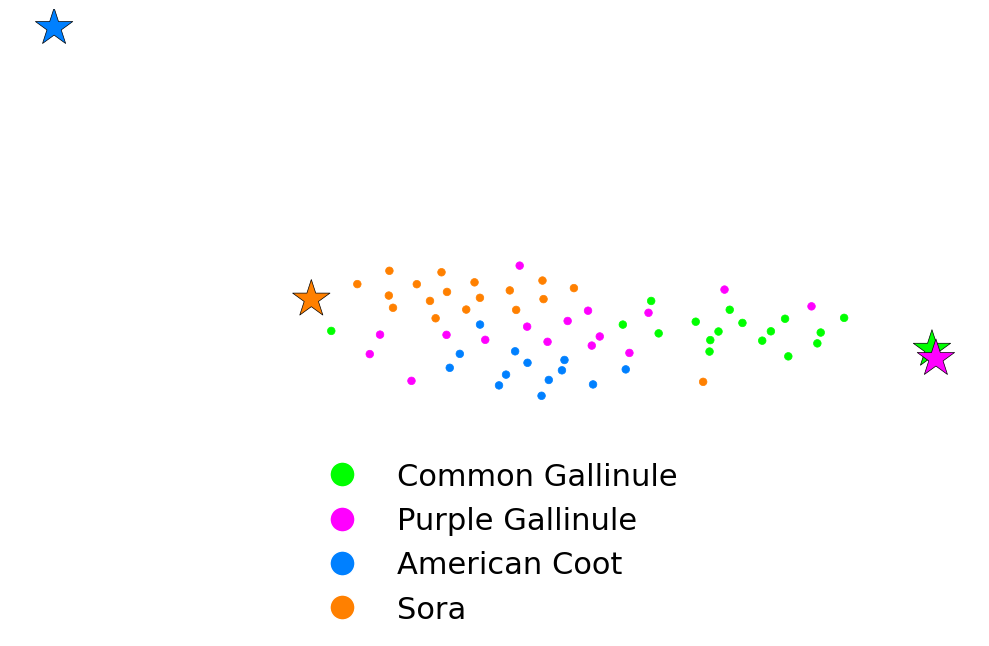

In [136]:
x, y = prepare_embeddings(torch.tensor(all_img_embeds), model.get_classifier().cpu())
visualize_clip_embeddings(image_embeddings=x, text_prototypes=y, classnames=classnames, gt_classes=gt_labels_val, color_list=color_list, legend=True, 
                          filter_classes=['Common Gallinule', 'Purple Gallinule', 'American Coot', 'Sora'], 
                          # orig_images=all_orig_imgs, figsize=(12, 8)
                          save_path='resisc45_ours.pdf', figsize=(10, 6)
                          )

# Not Important

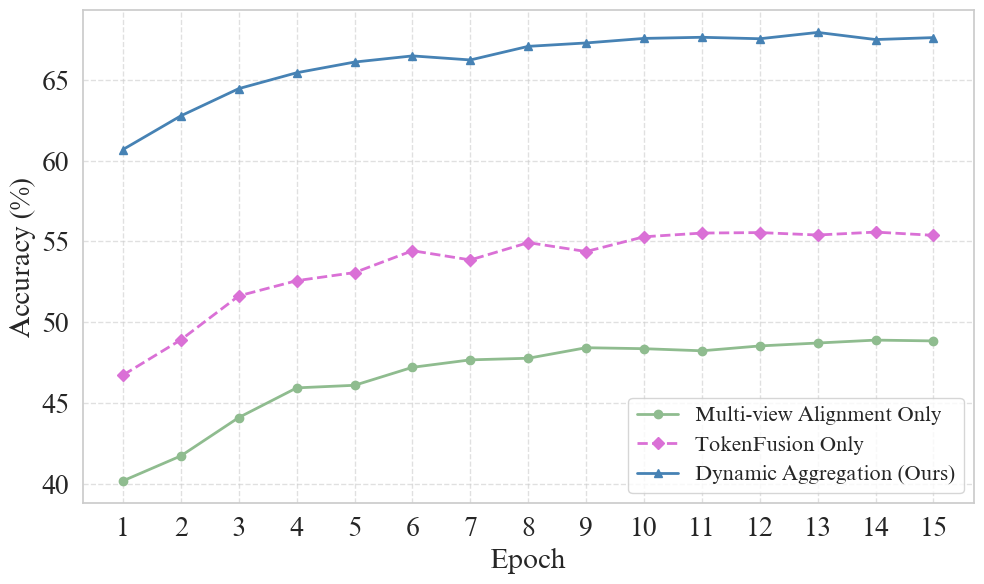

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm

# Load custom font from local path
font_path = "./times.ttf"
times_font = fm.FontProperties(fname=font_path, size=20)

# Enable pastel style
sns.set(style="whitegrid")
sns.set_palette("pastel")

# Epochs (1 to 15)
epochs = list(range(1, 16))

# Accuracy values
train_TokenFusion_acc_PL = [
    52.01, 57.01, 59.70, 62.02, 63.29, 64.15, 64.05,
    64.99, 65.42, 65.50, 65.94, 65.82, 66.48, 66.21, 66.16
]
train_WCA_acc_PL = [
    40.22, 41.76, 44.13, 45.96, 46.12, 47.23, 47.69,
    47.79, 48.44, 48.38, 48.25, 48.55, 48.73, 48.91, 48.86
]
train_acc_PL = [
    60.68, 62.76, 64.44, 65.42, 66.08, 66.46, 66.21,
    67.05, 67.26, 67.54, 67.61, 67.52, 67.91, 67.47, 67.59
]
train_TokenFusionOnly_acc_PL = [
    46.75, 48.93, 51.64, 52.58, 53.08, 54.43, 53.86,
    54.93, 54.38, 55.29, 55.52, 55.55, 55.40, 55.58, 55.38
]

# Create plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_WCA_acc_PL, marker='o', label='Multi-view Alignment Only', linewidth=2, color='#8FBC8F')
plt.plot(epochs, train_TokenFusionOnly_acc_PL, marker='D', linestyle='--', label='TokenFusion Only', linewidth=2, color='#DA70D6')
# plt.plot(epochs, train_TokenFusion_acc_PL, marker='s', label='TokenFusion', linewidth=2, color='#F4A460')
plt.plot(epochs, train_acc_PL, marker='^', label='Dynamic Aggregation (Ours)', linewidth=2, color='#4682B4')

# Apply custom font to all text elements
# plt.title('Train Pseudo-Label Accuracy over Epochs', fontsize=16, fontproperties=times_font)
plt.xlabel('Epoch', fontproperties=times_font)
plt.ylabel('Accuracy (%)', fontproperties=times_font)
plt.xticks(epochs, fontproperties=times_font)
plt.yticks(fontproperties=times_font)
small_font = fm.FontProperties(fname=font_path, size=15)
plt.legend(prop=small_font)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('pseudo_label_accuracy.pdf', dpi=300)

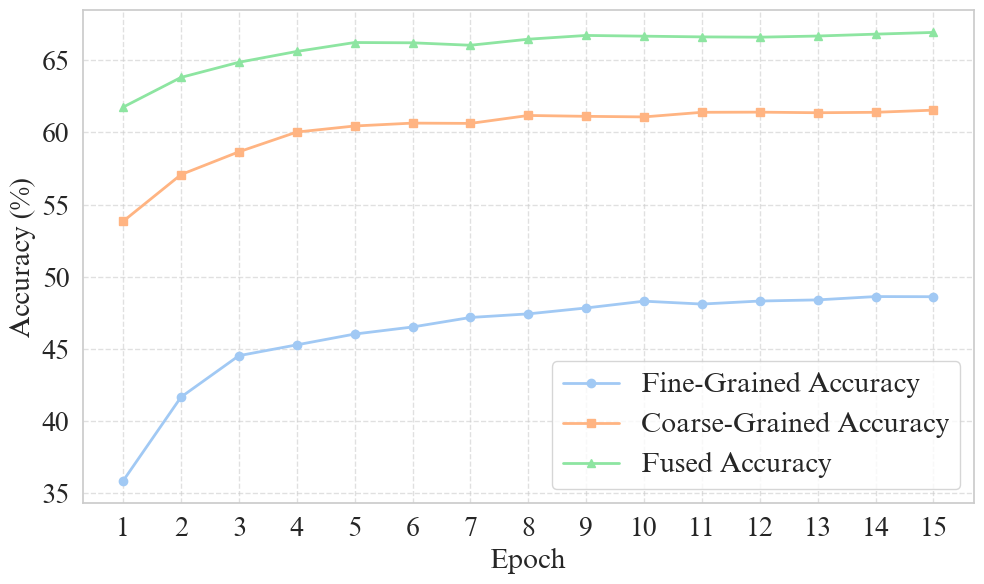

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm

# Load custom font from local path
font_path = "./times.ttf"
times_font = fm.FontProperties(fname=font_path, size=20)

# Enable pastel style
sns.set(style="whitegrid")
sns.set_palette("pastel")

# Epochs (1 to 15)
epochs = list(range(1, 16))

# Test accuracy values
test_acc_local = [
    35.84, 41.65, 44.52, 45.27, 46.02, 46.51, 47.17,
    47.42, 47.83, 48.30, 48.10, 48.31, 48.39, 48.62, 48.61
]
test_acc_global = [
    53.84, 57.08, 58.66, 60.03, 60.45, 60.65, 60.63,
    61.18, 61.12, 61.08, 61.40, 61.41, 61.37, 61.40, 61.55
]
test_acc = [
    61.76, 63.82, 64.87, 65.62, 66.24, 66.22, 66.05,
    66.47, 66.73, 66.68, 66.63, 66.61, 66.69, 66.82, 66.94
]

# Create plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, test_acc_local, marker='o', label='Fine-Grained Accuracy', linewidth=2)
plt.plot(epochs, test_acc_global, marker='s', label='Coarse-Grained Accuracy', linewidth=2)
plt.plot(epochs, test_acc, marker='^', label='Fused Accuracy', linewidth=2)

# Apply custom font
# plt.title('Test Accuracy over Epochs', fontsize=16, fontproperties=times_font)
plt.xlabel('Epoch', fontproperties=times_font)
plt.ylabel('Accuracy (%)', fontproperties=times_font)
plt.xticks(epochs, fontproperties=times_font)
plt.yticks(fontproperties=times_font)
plt.legend(prop=times_font)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('test_accuracy.pdf', dpi=300)

## Statistical Analyses

In [12]:
sum(Counter([x.item() for x in model.text_labels]).values()) / len(classnames)

90.0

In [13]:
def evaluate(data_loader, model, device, classnames=None, show_per_class=False, show_harmonic_mean=False):
    from collections import defaultdict
    import torch
    
    metric_logger = utils.MetricLogger(delimiter="  ")
    header = 'Test:'
    
    # Dictionary to store per-class metrics
    class_correct = defaultdict(int)
    class_total = defaultdict(int)
    
    # Switch to evaluation mode
    model.eval()
    for batch in metric_logger.log_every(data_loader, 10, header):
        inputs = batch[0].to(device, non_blocking=True)
        target = batch[1].to(device, non_blocking=True)
        
        # Compute output
        feat_test = model(inputs)
        output = 100. * feat_test @ model.get_classifier().t()
        
        # Compute predictions and accumulate per-class metrics
        _, preds = torch.max(output, 1)
        correct = preds.eq(target)

        for t, p in zip(target, correct):
            class_correct[t.item()] += p.item()
            class_total[t.item()] += 1
        
        # Overall accuracy
        acc = accuracy(output, target)[0]
        metric_logger.meters['acc'].update(acc.item(), n=inputs.shape[0])
    
    # Calculate and display per-class accuracy
    if show_per_class and classnames is not None:
        print("\nPer-Class Accuracy Results:")
        accuracies = []
        for label, total in class_total.items():
            classname = classnames[label]  # Use the classnames argument provided
            correct = class_correct[label]
            if total > 0:
                ACC = 100.0 * correct / total
                if ACC > 0:  # Only include non-zero accuracies for harmonic mean
                    accuracies.append(ACC / 100.0)  # Convert percentage to decimal
                print(
                    "* class: {} ({})\t"
                    "total: {:,}\t"
                    "correct: {:,}\t"
                    "acc: {:.2f}%".format(
                        label, classname, total, correct, ACC 
                    )
                )
        
        # Calculate Mean Accuracy
        mean_accuracy = sum(accuracies) / len(accuracies) if accuracies else 0.0
        print(f"\n* Mean Accuracy: {mean_accuracy * 100:.2f}%")

        # Calculate Harmonic Mean Accuracy (if enabled and non-zero accuracies exist)
        if show_harmonic_mean and len(accuracies) > 0:
            harmonic_mean_accuracy = len(accuracies) / sum(1.0 / acc for acc in accuracies)
            print(f"* Harmonic Mean Accuracy: {harmonic_mean_accuracy * 100:.2f}%")

    # Overall accuracy across all classes
    print(f"\n* Overall Acc@1: {metric_logger.acc.global_avg:.3f}")   
    return {k: meter.global_avg for k, meter in metric_logger.meters.items()}

In [14]:
evaluate(data_loader_val, model, device, show_per_class=True, classnames=classnames, show_harmonic_mean=True)

Test:  [ 0/32]  acc: 60.5469 (60.5469)
Test:  [10/32]  acc: 56.7472 (56.7472)
Test:  [20/32]  acc: 59.6875 (59.7284)
Test:  [30/32]  acc: 65.8008 (62.5882)
Test:  [31/32]  acc: 69.0013 (62.9026)
Test: Total time: 0:00:07 (0.2349 s / it)

Per-Class Accuracy Results:
* class: 0 (AM General Hummer SUV 2000)	total: 44	correct: 40	acc: 90.91%
* class: 1 (Acura RL Sedan 2012)	total: 32	correct: 5	acc: 15.62%
* class: 2 (Acura TL Sedan 2012)	total: 43	correct: 32	acc: 74.42%
* class: 3 (Acura TL Type-S 2008)	total: 42	correct: 7	acc: 16.67%
* class: 4 (Acura TSX Sedan 2012)	total: 40	correct: 22	acc: 55.00%
* class: 5 (Acura Integra Type R 2001)	total: 44	correct: 42	acc: 95.45%
* class: 6 (Acura ZDX Hatchback 2012)	total: 39	correct: 31	acc: 79.49%
* class: 7 (Aston Martin V8 Vantage Convertible 2012)	total: 45	correct: 14	acc: 31.11%
* class: 8 (Aston Martin V8 Vantage Coupe 2012)	total: 41	correct: 18	acc: 43.90%
* class: 9 (Aston Martin Virage Convertible 2012)	total: 33	correct: 6	acc: 1

{'acc': 62.90262411815168}

In [12]:
[(classnames[label.item()], classnames[x.item()], text) for label, x, text in zip(model.text_labels, torch.argmax(model.all_desc_embeddings.flatten(0, 1) @ model.get_classifier().t(), dim=-1), model.all_texts) if label.item() != x.item()]

[('AM General Hummer SUV 2000',
  'Audi V8 Sedan 1994',
  'The vehicle is a four-wheel drive SUV that was introduced in 1992.'),
 ('AM General Hummer SUV 2000',
  'Chevrolet HHR SS 2010',
  'This car is a big, tough SUV that is perfect for off-road adventures.'),
 ('AM General Hummer SUV 2000',
  'Plymouth Neon Coupe 1999',
  ' " designed for civilians to feel like they\'re in the military.'),
 ('AM General Hummer SUV 2000',
  'Plymouth Neon Coupe 1999',
  'There is no one definitive answer to this question, as there can be variations among different models and years.'),
 ('AM General Hummer SUV 2000',
  'Chevrolet HHR SS 2010',
  'This car is a large, boxy SUV with a square look.'),
 ('Acura RL Sedan 2012',
  'Acura TL Sedan 2012',
  "The acronym RL is short for Refine Luxury, and the RL is Acura's flagship sedan."),
 ('Acura RL Sedan 2012',
  'Chevrolet HHR SS 2010',
  'The RL Sedan is a comfortable car that is great for long drives.'),
 ('Acura RL Sedan 2012',
  'Chevrolet HHR SS 20

In [20]:
outliers = list(Counter([classnames[label.item()] for label, x, text in zip(model.text_labels, torch.argmax(model.all_desc_embeddings.flatten(0, 1) @ model.get_classifier().t(), dim=-1), model.all_texts) if label.item() != x.item()]).values())
sum(outliers) / len(classnames)

3.8520408163265305

In [21]:
len(outliers)

180

In [22]:
(model.get_classifier() @ model.get_classifier().t()).fill_diagonal_(0).mean()

tensor(0.6055, device='cuda:0', grad_fn=<MeanBackward0>)

In [25]:
all_img_embeddings = [[] for _ in range(len(classnames))]
all_img_labels = []
for img, label in data_loader_train:
    img = img[:, 0].to(device)
    with torch.no_grad():
        img_embedding = model(img)
    for i in range(len(img_embedding)):
        all_img_embeddings[label[i].item()].append(img_embedding[i])
        all_img_labels.append(label[i].item())

In [26]:
all_img_embeddings = [torch.stack(x) for x in all_img_embeddings]

In [27]:
img_prototypes = torch.stack([x.mean(dim=0) for x in all_img_embeddings])
(img_prototypes @ img_prototypes.t()).fill_diagonal_(0).mean()

tensor(0.5776, device='cuda:0')

In [28]:
(img_prototypes @ img_prototypes.t()).diag().mean()

tensor(0.7680, device='cuda:0')

In [29]:
(torch.argmax(img_prototypes @ img_prototypes.t(), dim=-1) != torch.arange(len(classnames)).to(device)).sum()

tensor(6, device='cuda:0')

In [30]:
outliers = list(Counter([classnames[label] for label, x in zip(all_img_labels, torch.argmax(torch.cat(all_img_embeddings) @ model.get_classifier().t(), dim=-1)) if label != x.item()]).values())
sum(outliers) / len(classnames)

41.33673469387755

In [32]:
len([1 for label, x in zip(all_img_labels, torch.argmax(100 * torch.cat(all_img_embeddings) @ model.get_classifier().t(), dim=-1)) if label == x.item()])

42

In [36]:
(img_prototypes @ model.get_classifier().t()).diag().mean()

tensor(0.3411, device='cuda:0', grad_fn=<MeanBackward0>)

In [35]:
(img_prototypes @ model.get_classifier().t()).mean()

tensor(0.1802, device='cuda:0', grad_fn=<MeanBackward0>)

In [34]:
(torch.cat(all_img_embeddings) @ torch.cat(all_img_embeddings).t()).fill_diagonal_(0).mean()

tensor(0.5811, device='cuda:0')

## t-SNE Visualizations

In [13]:
def prepare_embeddings(img_embeddings, txt_embeddings):
    U, s, V = torch.svd(txt_embeddings.t().to(torch.float32))
    txt_proj = U[:, 1:] @ U[:, 1:].t()
    # Remove class-agnostic information from visual embeddings.
    img_embeddings = F.normalize(img_embeddings @ txt_proj, dim=-1)
    # Remove redundant information from text embeddings.
    txt_embeddings = F.normalize(txt_embeddings @ txt_proj, dim=-1)
    return img_embeddings, txt_embeddings

In [68]:
def visualize_clip_embeddings(image_embeddings=None, 
                              text_embeddings=None, 
                              image_prototypes=None, 
                              text_prototypes=None, 
                              classnames=None, 
                              gt_classes=None, 
                              orig_images=None,
                              random_seed=42, 
                              perplexity=30, 
                              n_iter=1000,
                              save_path=None,
                              figsize=(12, 12),
                              legend=True,
                              color_list=None,
                              filter_classes=None):
    """
    Visualize CLIP embeddings using t-SNE and Seaborn.

    Args:
        image_embeddings (np.array): Image embeddings of shape (num_images, embed_dim).
        text_embeddings (np.array): Text embeddings of shape (num_texts, embed_dim).
        image_prototypes (np.array): Image prototypes of shape (num_classes, embed_dim).
        text_prototypes (np.array): Text prototypes of shape (num_classes, embed_dim).
        classnames (list): List of class names for the embeddings. Optional.
        gt_classes (np.array): Ground-truth class labels for image and/or text embeddings. Optional.
        random_seed (int): Random seed for t-SNE. Default is 42.
        perplexity (int): Perplexity parameter for t-SNE. Default is 30.
        n_iter (int): Number of iterations for t-SNE optimization. Default is 1000.

    Returns:
        None. Displays the t-SNE plot.
    """
    embeddings = []
    labels = []
    types = []  # To distinguish between image, text, and prototypes
    class_order = []  # To maintain order of classes for color assignment

    if gt_classes is not None and filter_classes is not None:
        gt_classes = [x for x, y in zip(gt_classes, color_list) if classnames[y] in filter_classes]
    
    # Check for available embeddings and add them to a single list
    if image_embeddings is not None:
        mask = np.ones(len(image_embeddings), dtype=bool)
        if filter_classes is not None:
            mask = np.array([classnames[x] in filter_classes for x in color_list])
            image_embeddings = image_embeddings[mask]
        embeddings.append(image_embeddings)
        labels.extend(gt_classes if gt_classes is not None else [-1] * len(image_embeddings))
        types.extend(['Image Embeddings'] * len(image_embeddings))
        class_order.extend(gt_classes if gt_classes is not None else [])

    if text_embeddings is not None:
        embeddings.append(text_embeddings)
        labels.extend(gt_classes if gt_classes is not None else [-1] * len(text_embeddings))
        types.extend(['Text Embeddings'] * len(text_embeddings))
        class_order.extend(gt_classes if gt_classes is not None else [])

    if image_prototypes is not None:
        embeddings.append(image_prototypes)
        labels.extend(list(range(len(image_prototypes))))  # Assuming prototypes are arranged as class order
        types.extend(['Image Prototypes'] * len(image_prototypes))
        class_order.extend(list(range(len(image_prototypes))))

    if text_prototypes is not None:
        if filter_classes is not None:
            text_prototypes = np.vstack([x for i, x in enumerate(text_prototypes) if classnames[i] in filter_classes])
        embeddings.append(text_prototypes)
        labels.extend(list(range(len(text_prototypes))))  # Assuming prototypes are arranged as class order
        types.extend(['Text Prototypes'] * len(text_prototypes))
        class_order.extend(list(range(len(text_prototypes))))

    # If no embeddings are provided, return
    if len(embeddings) == 0:
        print("No embeddings provided for visualization.")
        return

    # Stack all embeddings together and apply t-SNE
    embeddings_combined = np.vstack(embeddings)
    num_non_text_embeddings = embeddings_combined.shape[0] - (len(text_prototypes) if text_prototypes is not None else 0)
    tsne = TSNE(n_components=2, random_state=random_seed, perplexity=perplexity, n_iter=n_iter)
    embeddings_2d = tsne.fit_transform(embeddings_combined)

    if filter_classes is not None:
        classnames = filter_classes

    # Use when classnames are provided
    if classnames is not None:
        # Generate visually distinct colors
        palette = distinctipy.get_colors(len(classnames))
        label_dict = {i: f'{classnames[i]}' for i in range(len(classnames))}
    else:
        unique_labels = set(labels)
        palette = distinctipy.get_colors(len(unique_labels))
        label_dict = {i: f'Class {i}' for i in unique_labels}
    
    # Create a Pandas DataFrame for plotting
    df = pd.DataFrame({
        'x': embeddings_2d[:, 0],
        'y': embeddings_2d[:, 1],
        'label': labels,
        'type': types
    })

    # Create a dynamic marker dictionary based on unique types
    unique_types = df['type'].unique()
    markers = {
        'Image Embeddings': 'o',
        'Text Embeddings': 'o',   # Circles with border in plot command
        'Image Prototypes': '*',
        'Text Prototypes': '*'
    }

    jitter_amount = 0.2
    df['x'] += np.random.uniform(-jitter_amount, jitter_amount, size=len(df))
    df['y'] += np.random.uniform(-jitter_amount, jitter_amount, size=len(df))

    # Create the plot
    plt.figure(figsize=figsize)

    j = 0
    if orig_images is not None:
        for class_idx, class_images in enumerate(orig_images):
            if class_images and len(class_images) >= 3:  # Ensure at least 3 images per class
                all_indices = [i for i, lbl in enumerate(labels[:num_non_text_embeddings]) if lbl == class_idx]
                if len(all_indices) >= 3:
                    class_indices = random.sample(all_indices, 3)
                else:
                    class_indices = all_indices  # Use all if fewer than 3
                if classnames[class_idx] in filter_classes:
                    print(f'Class {class_idx}: {len(class_indices)} images')
                for img_idx, emb_idx in enumerate(class_indices):
                    x, y = embeddings_2d[emb_idx]
                    image = class_images[img_idx]

                    # Resize PIL image to fixed width and maintain aspect ratio
                    aspect_ratio = image.height / image.width
                    new_height = int(85 * aspect_ratio)
                    resized_image = image.resize((85, new_height))

                    border_color = tuple([int(c * 255) for c in palette[j]])  # RGB tuple
                    bordered_image = ImageOps.expand(resized_image, border=3, fill=border_color)

                    # Convert bordered image to array
                    image_array = np.array(bordered_image)

                    # Add the image with a border to the plot
                    im = OffsetImage(image_array, zoom=1)  # Zoom is unused with fixed pixel size
                    ab = AnnotationBbox(im, (x, y), frameon=False)
                    plt.gca().add_artist(ab)
                    
                if len(class_indices) > 0: j+=1

    # Plot embeddings with adjusted sizes
    for marker_type in unique_types:
        type_df = df[df['type'] == marker_type]
        
        # Use different sizes and edge colors for text/image embeddings
        marker_size = 30 if 'Embeddings' in marker_type else 800  # Smaller circles, larger stars
        edgecolor = 'black' if 'Prototypes' in marker_type else None
        
        sns.scatterplot(data=type_df, x='x', y='y', hue='label', 
                        style='type', markers=[markers[marker_type]],
                        palette=palette, s=marker_size, edgecolor=edgecolor, legend=False, linewidth=0.5, zorder=10)

    # Add labels above the prototypes for class indices
    if image_prototypes is not None or text_prototypes is not None:
        prototype_type = 'Image Prototypes' if image_prototypes is not None else 'Text Prototypes'
        prototype_df = df[df['type'] == prototype_type]
        
        # for _, row in prototype_df.iter
        # rows():
        #     plt.text(row['x'], row['y'] + 1, f'{int(row["label"])}', fontsize=12, ha='center', va='bottom')

    # Customize the legend to show color-label mapping in multiple rows
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=palette[i], markersize=18, 
                          label=label_dict[i]) for i in range(len(label_dict))]
    
    # Calculate the number of rows based on the number of classes
    num_classes = len(label_dict)
    legend_rows = max(1, int(np.ceil(num_classes / 5)))  # Set the number of rows dynamically

    if legend:
        plt.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=legend_rows, frameon=False, fontsize=22)

    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.xlabel('')
    plt.ylabel('')

    # plt.title("t-SNE Visualization of CLIP Embeddings")
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.3)
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')

In [57]:
per_class_embeds_val = {cls: [] for cls in classnames}
per_pred_class_embeds_val = {cls: [] for cls in classnames}
gt_labels_val = []
pred_labels_val = []

for (image, gt_label, idx) in data_loader_val:
    image = image.to(device, non_blocking=True)
    orig_image = [Image.open(dataset_val.samples[i][0]) for i in idx]
    with torch.no_grad():
        global_feats, local_feats, attn_map = get_local_global_features(args, image, model, None, normalize=True)
    global_logits = 100 * global_feats @ model.get_classifier().T
    local_logits = 100 * local_feats @ model.get_classifier().T
    logits = (global_logits + local_logits) / 2
    probas = torch.softmax(logits, dim=-1)
    pred_label = torch.argmax(logits, dim=-1)
    for i in range(len(gt_label)):
        per_class_embeds_val[classnames[gt_label[i]]].append(dict(
            # id=id[i],
            global_embeds=global_feats[i].cpu().detach().float(),
            local_embeds=local_feats[i].cpu().detach().float(),
            confidence=probas[i, gt_label[i]],
            orig_image=orig_image[i]
        ))
        per_pred_class_embeds_val[classnames[pred_label[i]]].append(dict(
            # id=id[i],
            global_embeds=global_feats[i].cpu().detach().float(),
            local_embeds=local_feats[i].cpu().detach().float(),
            confidence=probas[i, gt_label[i]],
            orig_image=orig_image[i]
        ))
        gt_labels_val.append(gt_label[i].item())
        pred_labels_val.append(pred_label[i].item())

In [58]:
top_k = 500
all_img_embeds = []
all_refined_embeds = []
color_list = []
top_confs = []
all_orig_imgs = []

classnames = list(per_class_embeds_val.keys())
for i, cls in enumerate(classnames):
    confidences = [(s['confidence'].item(), i) for i, s in enumerate(per_class_embeds_val[cls])]
    confidences = sorted(confidences, key=lambda x: x[0], reverse=True)
    most_conf_ids = [c[1] for c in confidences[:top_k]]
    top_confs.append([c[0] for c in confidences[:top_k]])
    # img_embeds = [F.normalize((s['global_embeds'] + s['local_embeds']) / 2, dim=-1).detach().numpy() for i, s in enumerate(per_class_embeds_val[cls]) if i in most_conf_ids]
    img_embeds = [s['global_embeds'].detach().numpy() for i, s in enumerate(per_class_embeds_val[cls]) if i in most_conf_ids]
    refined_embeds = [s['local_embeds'].detach().numpy() for i, s in enumerate(per_class_embeds_val[cls]) if i in most_conf_ids]
    all_orig_imgs.append([s['orig_image'] for i, s in enumerate(per_class_embeds_val[cls]) if i in most_conf_ids])
    all_img_embeds += img_embeds
    all_refined_embeds += refined_embeds
    color_list += [i] * len(img_embeds)

Class 0: 0 images
Class 1: 0 images
Class 2: 3 images


IndexError: list index out of range

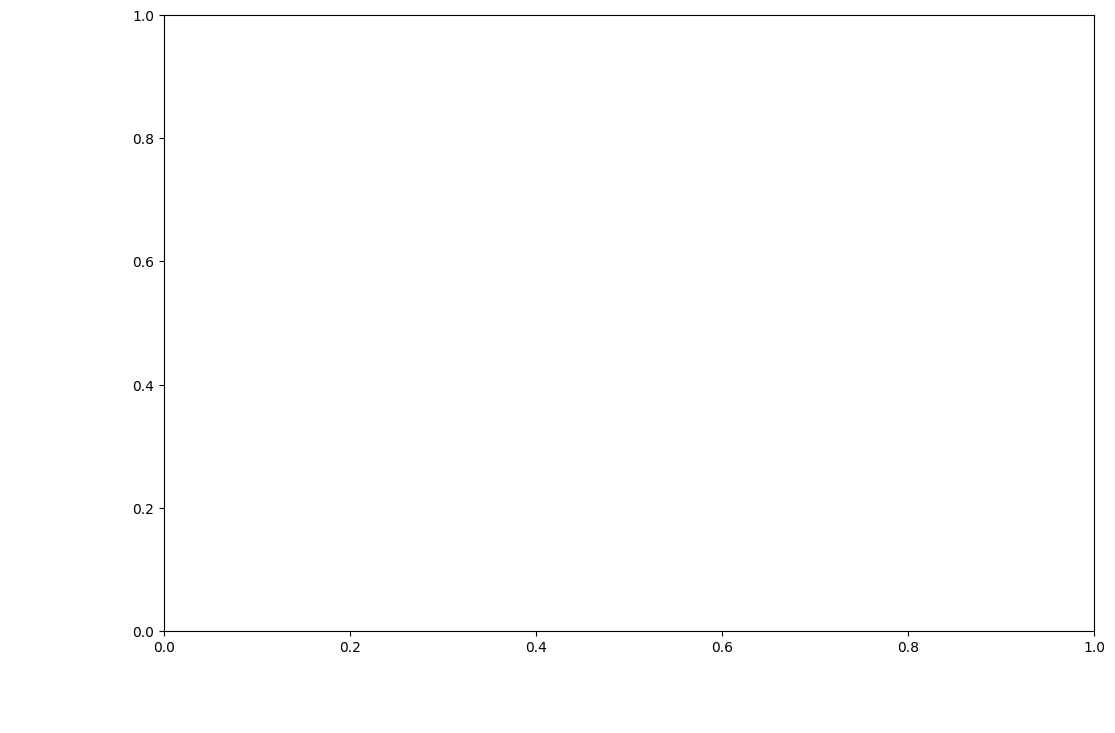

In [69]:
x, y = prepare_embeddings(torch.tensor(all_img_embeds), model.get_classifier().cpu())
visualize_clip_embeddings(image_embeddings=x, text_prototypes=y, classnames=classnames, gt_classes=gt_labels_val, color_list=color_list, legend=False, 
                          filter_classes=['baseball diamond', 'ground track field', 'stadium'], orig_images=all_orig_imgs, figsize=(12, 8), save_path='resisc45_tsne.pdf')

In [ ]:
x, y = prepare_embeddings(torch.tensor(all_img_embeds), model.get_classifier().cpu())
visualize_clip_embeddings(image_embeddings=x, text_prototypes=y[:10], classnames=classnames[:10], gt_classes=color_list)

In [ ]:
x, y = prepare_embeddings(torch.tensor(all_refined_embeds), model.classname_embeddings.cpu())
visualize_clip_embeddings(image_embeddings=x, text_prototypes=y[:10], classnames=classnames[:10], gt_classes=color_list)

In [ ]:
x, y = prepare_embeddings(torch.tensor(all_refined_embeds), model.get_classifier().cpu())
visualize_clip_embeddings(image_embeddings=x, text_prototypes=y[:10], classnames=classnames[:10], gt_classes=color_list)

In [ ]:
x, y = prepare_embeddings(model.all_desc_embeddings.flatten(0, 1).cpu(), model.get_fixed_classifier().cpu())
color_list = [[i] * len(model.all_desc_embeddings[i]) for i in range(len(model.learnable_desc_embeddings))]
color_list = [item for sublist in color_list for item in sublist]
visualize_clip_embeddings(image_embeddings=x, text_prototypes=y, classnames=classnames, gt_classes=color_list)

In [ ]:
x, y = prepare_embeddings(model.learnable_desc_embeddings.flatten(0, 1).cpu(), model.get_classifier().cpu())
color_list = [[i] * len(model.learnable_desc_embeddings[i]) for i in range(len(model.learnable_desc_embeddings))]
color_list = [item for sublist in color_list for item in sublist]
visualize_clip_embeddings(image_embeddings=x, text_prototypes=y, classnames=classnames, gt_classes=color_list)

In [42]:
(model.get_fixed_classifier() @ model.get_fixed_classifier().t()).fill_diagonal_(0).mean()

tensor(0.7900, device='cuda:2')

In [43]:
(model.get_classifier() @ model.get_classifier().t()).fill_diagonal_(0).mean()

tensor(0.7554, device='cuda:2')

/home/muhammad.haris/miniconda3/envs/dassl/lib/python3.7/site-packages/ipykernel_launcher.py:160: UserWarning: The palette list has more values (37) than needed (1), which may not be intended.


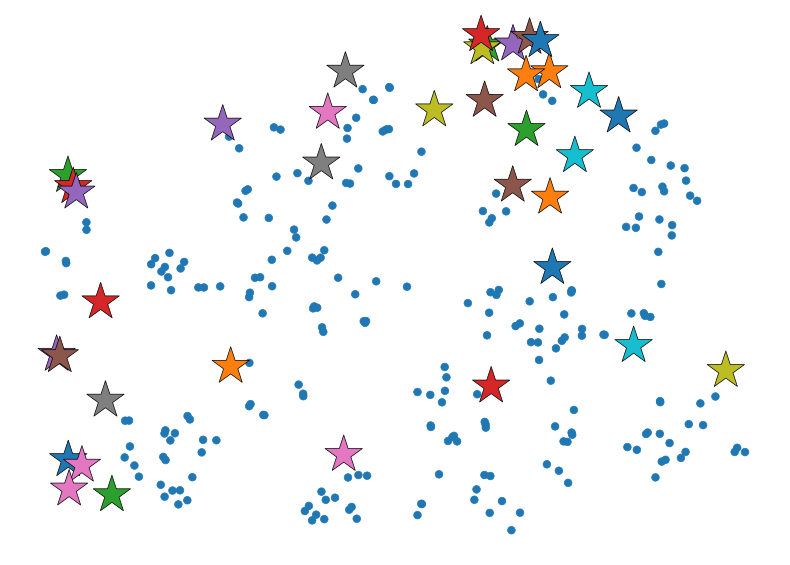

In [ ]:
x, y = prepare_embeddings(model.all_attributes.cpu(), model.attr_embeddings.cpu())
visualize_clip_embeddings(image_embeddings=x, image_prototypes=y, classnames=classnames, figsize=(8, 8), legend=False)

In [27]:
(model.attr_embeddings @ model.attr_embeddings.t()).fill_diagonal_(0).mean()

tensor(0.8255, device='cuda:0')

In [25]:
(model.clip_model.classifier @ model.clip_model.classifier.t()).fill_diagonal_(0).mean()

tensor(0.5725, device='cuda:0')

In [16]:
img_embeds, text_prototypes = prepare_embeddings(torch.tensor(all_img_embeds), model.get_classifier().detach().cpu())
all_img_embeddings = img_embeds.detach().cpu().numpy()
text_prototypes = text_prototypes.detach().cpu().numpy()

/home/muhammad.haris/miniconda3/envs/dassl/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  """Entry point for launching an IPython kernel.


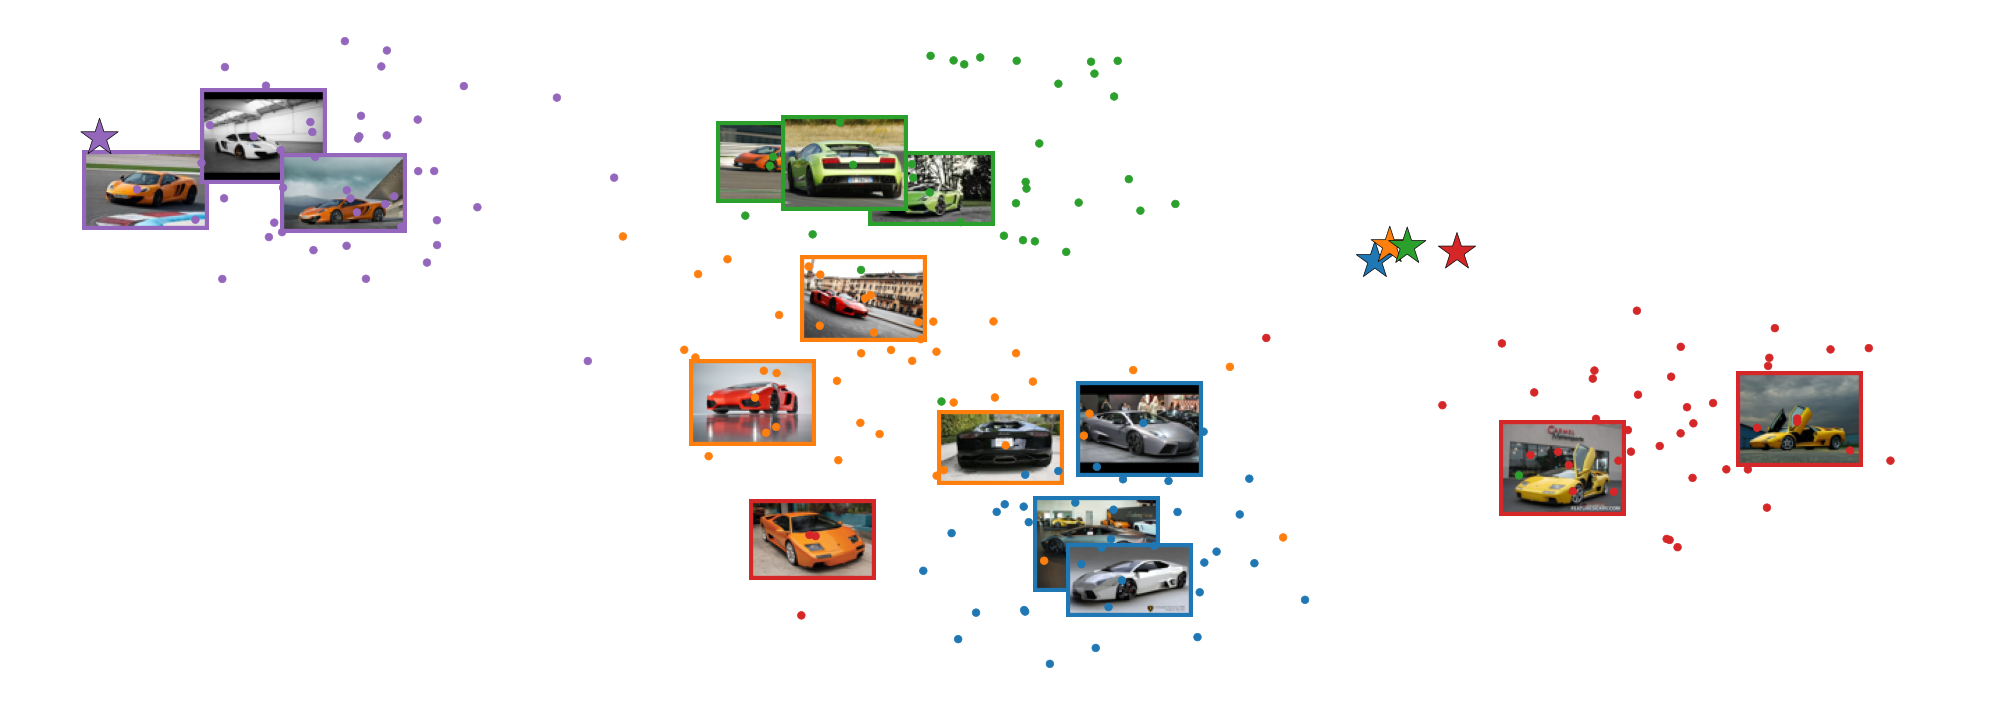

In [88]:
visualize_clip_embeddings(image_embeddings=all_img_embeddings, text_prototypes=text_prototypes, classnames=classnames, gt_classes=gt_labels_val, save_path='cars_tsne.png', \
    legend=False, color_list=color_list, figsize=(20, 10), \
        filter_classes=['Lamborghini Aventador Coupe 2012', 'Lamborghini Gallardo LP 570-4 Superleggera 2012', 'Lamborghini Reventon Coupe 2008', 'Lamborghini Diablo Coupe 2001', 'McLaren MP4-12C Coupe 2012'],\
            orig_images=all_orig_imgs)

Mean inter-class similarity:

In [13]:
(model.get_classifier() @ model.get_classifier().t()).fill_diagonal_(0).mean()

tensor(0.8376, device='cuda:0', grad_fn=<MeanBackward0>)

Maximum inter-class similarity:

In [14]:
(model.get_classifier() @ model.get_classifier().t()).fill_diagonal_(0).max()

tensor(0.9571, device='cuda:0', grad_fn=<MaxBackward1>)

Max inter-class similarity classes:

In [15]:
# Assuming model is defined and has a method get_classifier()
classifier = model.get_classifier()
similarity_matrix = classifier @ classifier.t()  # Shape: [num_classes, num_classes]
similarity_matrix.fill_diagonal_(0)  # Set diagonal to 0

# Find the argmax in the flattened tensor
max_index = torch.argmax(similarity_matrix)

# Manually compute the 2D indices from the flattened index
num_classes = similarity_matrix.size(0)
divmod(max_index.item(), num_classes)

(35, 41)

In [12]:
(model.get_classifier() @ model.get_classifier().t()).fill_diagonal_(0)[10, 30]

tensor(0.9541, device='cuda:0', grad_fn=<SelectBackward0>)

In [ ]:
visualize_clip_embeddings(text_embeddings=model.all_text_embeddings.detach().cpu().numpy(), text_prototypes=model.get_classifier().detach().cpu().numpy(), classnames=classnames, gt_classes=model.all_text_labels.detach().cpu().numpy())

Mean inter-class similarity:

In [13]:
(model.get_classifier() @ model.get_classifier().t()).fill_diagonal_(0).mean()

tensor(0.6911, device='cuda:0', grad_fn=<MeanBackward0>)

Maximum inter-class similarity:

In [19]:
(model.get_classifier() @ model.get_classifier().t()).fill_diagonal_(0).max()

(tensor(0.9327, device='cuda:0', grad_fn=<MaxBackward1>),
 tensor(17, device='cuda:0'))

Max inter-class similarity classes:

In [23]:
# Assuming model is defined and has a method get_classifier()
classifier = model.get_classifier()
similarity_matrix = classifier @ classifier.t()  # Shape: [num_classes, num_classes]
similarity_matrix.fill_diagonal_(0)  # Set diagonal to 0

# Find the argmax in the flattened tensor
max_index = torch.argmax(similarity_matrix)

# Manually compute the 2D indices from the flattened index
num_classes = similarity_matrix.size(0)
divmod(max_index.item(), num_classes)

(10, 30)

## Crops

In [17]:
def build_transform_testing(args):
    transform = T.Compose([
        T.Resize(args.input_size, interpolation=InterpolationMode.BICUBIC),
        T.ToTensor(),
        T.Normalize(
            mean=torch.tensor(args.image_mean),
            std=torch.tensor(args.image_std))
    ])
    return transform

In [18]:
def random_crop(image, alpha=0.5, beta=0.9):
    """
    Randomly crops an image based on a size range determined by alpha and the image dimensions.

    Args:
        image (PIL Image or Tensor): The input image to crop.
        alpha (float): The minimum scale factor for the crop, relative to the smallest dimension of the image.

    Returns:
        PIL Image or Tensor: Cropped image.
    """
    w, h = image.size
    crop_size = np.random.uniform(low=alpha, high=beta) * min(h, w)  # Crop size based on a random proportion of the smallest dimension
    cropped_image = T.RandomCrop(int(crop_size))(image)  # Apply random crop
    return cropped_image

In [19]:
def WCA_evaluation_one_iter(sampled_crop_embeds, crop_weights, classifier_weights=None, all_desc_embeds=None, sum_desc_weights=None, image_scale=4.0):
    # Weighted average of image embeddings
    w_i = (image_scale * crop_weights).unsqueeze(-1)
    sampled_crop_embeds = (sampled_crop_embeds * w_i).sum(dim=1) / w_i.sum(dim=1)
    sampled_crop_embeds = F.normalize(sampled_crop_embeds, dim=-1)
    
    if classifier_weights is None:
        all_desc_embeds = all_desc_embeds.sum(dim=1) / sum_desc_weights
        classifier_weights = F.normalize(all_desc_embeds, dim=-1)

    logits = sampled_crop_embeds @ classifier_weights.t()
    
    return logits

In [20]:
def min_max_normalization(pl_certainty: torch.Tensor):
    min_val = pl_certainty.min()
    max_val = pl_certainty.max()
    return (pl_certainty - min_val) / (max_val - min_val + 1e-8)

In [21]:
def get_weights(A, B, C, dataset_params):
    alpha = dataset_params['alpha']
    C = torch.clamp(C, min=0, max=1)  # Ensures (1 - C) does not become too large or too negative
    C_ = torch.exp(-alpha * (1 - C))
    trust_score = A * torch.abs(A - B) * (1 - C_)
    return trust_score

def custom_log_normalize(values, new_min, new_max):
    epsilon = 1e-6
    log_values = torch.log(values + epsilon)
    log_min = log_values.min()
    log_max = log_values.max()
    normalized_log_values = (log_values - log_min) / (log_max - log_min + epsilon)
    return normalized_log_values * (new_max - new_min) + new_min

In [26]:
all_desc_embeds, all_desc_weights = model.get_descriptions()

In [27]:
all_desc_embeds, all_desc_weights = model.get_descriptions()
all_desc_embeds = all_desc_embeds.to(device) # (num_classes, num_descriptions, embed_dim)
all_desc_weights = all_desc_weights.to(device) # (num_classes, num_descriptions)
all_desc_embeds = all_desc_embeds * all_desc_weights.unsqueeze(-1)
sum_desc_weights = all_desc_weights.sum(dim=-1, keepdim=True)

(-0.5, 223.5, 223.5, -0.5)

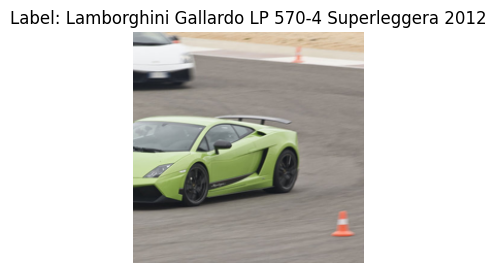

In [12]:
rand_id = np.random.randint(len(dataset_val))
# rand_id = 873
rand_id = 6186
# input, idx = dataset_val[rand_id]

try:
    img_path, label = dataset_val.samples[rand_id]
except:
    img_path, label = dataset_val.data[rand_id]

tfm1 = T.Compose([
    T.Resize(args.input_size, interpolation=InterpolationMode.BICUBIC),
    T.RandomCrop(args.input_size),
])
tfm2 = T.Compose([
    T.ToTensor(),
    T.Normalize(
        mean=torch.tensor(args.image_mean),
        std=torch.tensor(args.image_std))
])
    
img_orig = Image.open(img_path).convert('RGB')
img = tfm1(img_orig)
img_train_weak = tfm2(img).unsqueeze(0).cuda()

plt.figure(figsize=(4,3))
plt.imshow(img)
plt.title(f'Label: {classnames[label]}')
plt.axis('off')

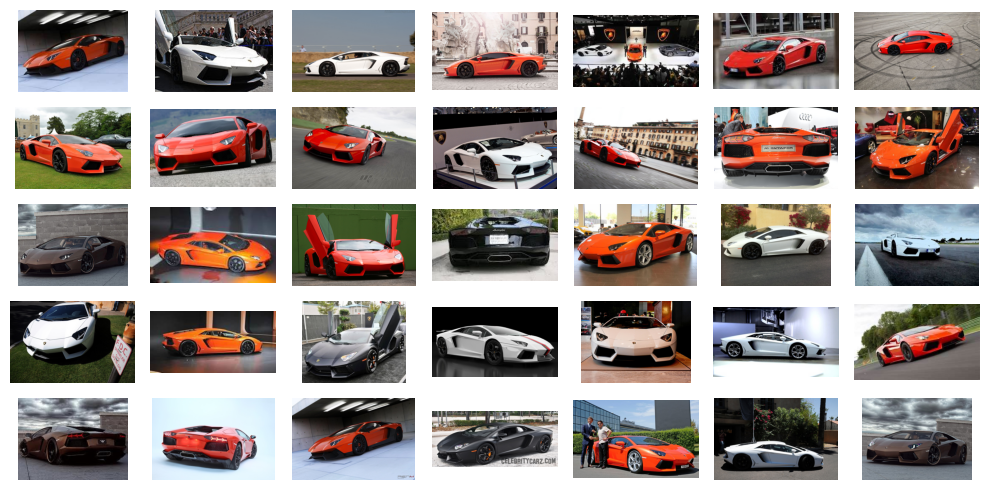

In [16]:
for i in range(len(dataset_val)):
    if dataset_val.samples[i][1] == classnames.index('Lamborghini Aventador Coupe 2012'):
        plt.figure(figsize=(10, 5))
        for j in range(35):
            img_path, _ = dataset_val.samples[i+j]
            img = Image.open(img_path).convert('RGB')
            plt.subplot(5, 7, j+1)
            plt.imshow(img)
            plt.axis('off')
        plt.tight_layout()
        plt.savefig('aventador.pdf', bbox_inches='tight', dpi=300)
        break

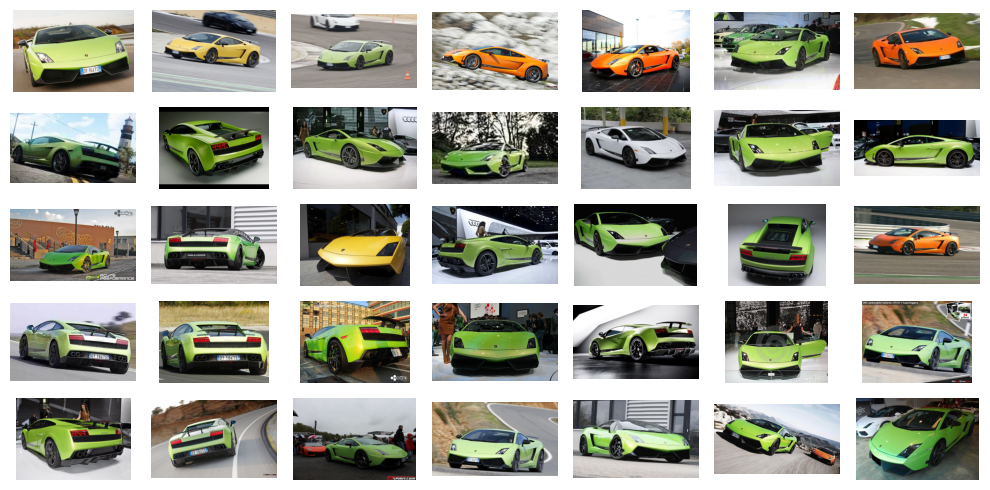

In [17]:
for i in range(len(dataset_val)):
    if dataset_val.samples[i][1] == classnames.index('Lamborghini Gallardo LP 570-4 Superleggera 2012'):
        plt.figure(figsize=(10, 5))
        for j in range(35):
            img_path, _ = dataset_val.samples[i+j]
            img = Image.open(img_path).convert('RGB')
            plt.subplot(5, 7, j+1)
            plt.imshow(img)
            plt.axis('off')
        plt.tight_layout()
        plt.savefig('gallardo.pdf', bbox_inches='tight', dpi=300)
        break

In [20]:
# tfm = build_transform_testing(args)
# crops = [random_crop(img_orig, alpha=0.7, beta=0.9) for _ in range(16)]
# crop_inputs = torch.stack([tfm(crop) for crop in crops]).to(device)

# crop_featss, crop_cls = model(crop_inputs, return_cls_token=True)
global_feat, global_cls = model(img_train_weak, return_cls_token=True)

In [21]:
torch.argmax(global_feat @ model.get_classifier().t(), dim=-1).item(), classnames[torch.argmax(global_feat @ model.get_classifier().t(), dim=-1).item()]

(150, 'Lamborghini Aventador Coupe 2012')

In [48]:
top_k_labels = torch.topk(global_feat @ model.get_classifier().t(), k=100, dim=-1).indices.flatten()
print({classnames[label.item()]: (global_feat @ model.get_classifier().t())[0, label].item() for label in top_k_labels})

{'Lamborghini Aventador Coupe 2012': 0.33099156618118286, 'Lamborghini Gallardo LP 570-4 Superleggera 2012': 0.3253304958343506, 'Lamborghini Reventon Coupe 2008': 0.2883778214454651, 'McLaren MP4-12C Coupe 2012': 0.2849500775337219, 'Ferrari 458 Italia Coupe 2012': 0.2552258372306824, 'Lamborghini Diablo Coupe 2001': 0.2535583972930908, 'Ferrari 458 Italia Convertible 2012': 0.2506029009819031, 'Audi R8 Coupe 2012': 0.2459430694580078, 'Chevrolet HHR SS 2010': 0.2431243658065796, 'Ford GT Coupe 2006': 0.23709045350551605, 'Ford Fiesta Sedan 2012': 0.21499526500701904, 'Chevrolet Corvette ZR1 2012': 0.2063748985528946, 'Land Rover LR2 SUV 2012': 0.20595446228981018, 'Bugatti Veyron 16.4 Coupe 2009': 0.2052566260099411, 'Bugatti Veyron 16.4 Convertible 2009': 0.20523163676261902, 'Land Rover Range Rover SUV 2012': 0.20046867430210114, 'Aston Martin V8 Vantage Coupe 2012': 0.20027562975883484, 'Volkswagen Golf Hatchback 2012': 0.197299987077713, 'Chevrolet Corvette Convertible 2012': 0.1

In [22]:
patch_tokens_img, patch_tokens_txt = model(img_train_weak, return_patch_tokens=True)
sim_patches = patch_tokens_img @ global_cls.t()
sim_patches = sim_patches.flatten().view(7, 7)

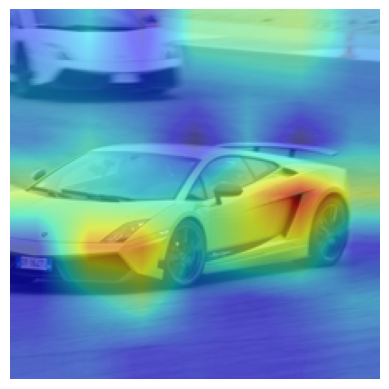

In [23]:
activation_map_resized = 1 - np.array(Image.fromarray(sim_patches.cpu().numpy()).resize((224, 224), resample=Image.BILINEAR))

plt.imshow(img)
plt.imshow(activation_map_resized, cmap='jet', alpha=0.5)  # Overlay the patch-wise activation map
plt.axis('off')
plt.show()

In [28]:
cls_desc = all_desc_embeds[label].mean(dim=0)
# sim_patches_txt = patch_tokens_txt @ cls_desc.t()
sim_patches_txt = patch_tokens_txt @ model.get_classifier()[label].t()
sim_patches_txt = sim_patches_txt.flatten().view(7, 7)

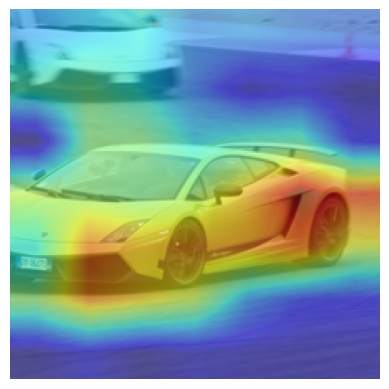

In [ ]:
activation_map_resized = 1 - np.array(Image.fromarray(sim_patches_txt.cpu().numpy()).resize((224, 224), resample=Image.BILINEAR))

plt.imshow(img)
plt.imshow(activation_map_resized, cmap='jet', alpha=0.5)  # Overlay the patch-wise activation map
plt.axis('off')
plt.show()

(-0.5, 223.5, 223.5, -0.5)

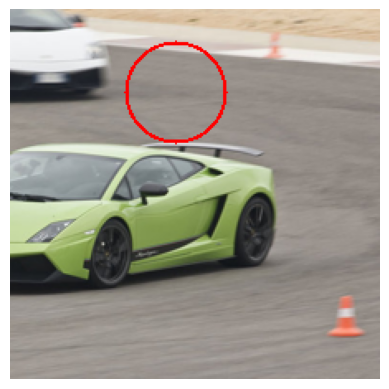

In [29]:
height, width = 224, 224

y = torch.arange(height, device='cuda').view(-1, 1)  # Column vector (H, 1)
x = torch.arange(width, device='cuda').view(1, -1)   # Row vector (1, W)

# Get the center and radius for the current image
center_y, center_x = 50, 100
radius = 30

# Calculate the distance from the center
distance_from_center = torch.sqrt((x - center_x) ** 2 + (y - center_y) ** 2)

# Create the circle mask for the border
circle_mask = (distance_from_center >= radius - 2 / 2) & \
                (distance_from_center <= radius + 2 / 2)

image = T.ToTensor()(img).clone().cuda()

# Apply the mask to set the circle border color
image[0, circle_mask]=1
image[1, circle_mask]=0
image[2, circle_mask]=0

plt.imshow(image.cpu().numpy().transpose((1,2,0)))
plt.axis('off')

In [41]:
def draw_red_circle(image, center, radius, color=(255, 0, 0), thickness=1):
    """
    Draws a non-filled circle border on the image, clipping if it goes out of bounds.

    Args:
        image (numpy.ndarray): The image as a 3D NumPy array (H, W, 3).
        center (tuple): The (y, x) coordinates of the circle's center.
        radius (int): The radius of the circle.
        color (tuple): The RGB color of the circle border.
        thickness (int): Thickness of the circle border.

    Returns:
        numpy.ndarray: The image with the circle border drawn.
    """
    height, width, _ = image.shape
    y_center, x_center = center
    
    # Generate a grid of indices
    y, x = np.ogrid[:height, :width]
    
    # Distance from the center
    distance_from_center = np.sqrt((x - x_center)**2 + (y - y_center)**2)
    
    # Create a mask for the circle border
    circle_mask = (distance_from_center >= radius - thickness / 2) & (distance_from_center <= radius + thickness / 2)
    
    # Apply the mask to set the circle border to the specified color
    image[circle_mask] = color
    
    return image

(-0.5, 223.5, 223.5, -0.5)

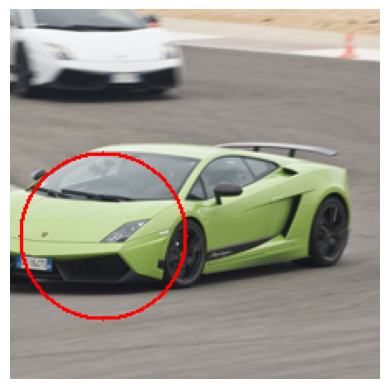

In [84]:
center = activation_map_resized.argmax() // 224 + 25, activation_map_resized.argmax() % 224 - 120
circled_image = draw_red_circle(np.array(img), center, 50, thickness=2)
plt.imshow(circled_image)
plt.axis('off')

In [85]:
circled_img = tfm2(circled_image).unsqueeze(0).cuda()
global_feat, global_cls = model(circled_img, return_cls_token=True)

top_k_labels = torch.topk(global_feat @ model.get_classifier().t(), k=100, dim=-1).indices.flatten()
print({classnames[label.item()]: (global_feat @ model.get_classifier().t())[0, label].item() for label in top_k_labels})

{'Lamborghini Aventador Coupe 2012': 0.3353428244590759, 'Lamborghini Gallardo LP 570-4 Superleggera 2012': 0.30904829502105713, 'Lamborghini Reventon Coupe 2008': 0.2951064705848694, 'McLaren MP4-12C Coupe 2012': 0.2694450616836548, 'Ferrari 458 Italia Convertible 2012': 0.25282108783721924, 'Audi R8 Coupe 2012': 0.2502140700817108, 'Lamborghini Diablo Coupe 2001': 0.2452932596206665, 'Ferrari 458 Italia Coupe 2012': 0.24488475918769836, 'Ford GT Coupe 2006': 0.24134428799152374, 'Chevrolet HHR SS 2010': 0.22703798115253448, 'Chevrolet Corvette ZR1 2012': 0.22245125472545624, 'Bugatti Veyron 16.4 Convertible 2009': 0.21605661511421204, 'Chevrolet Corvette Convertible 2012': 0.21512684226036072, 'Land Rover LR2 SUV 2012': 0.210012748837471, 'Bugatti Veyron 16.4 Coupe 2009': 0.20730940997600555, 'Ford Fiesta Sedan 2012': 0.20724180340766907, 'Aston Martin V8 Vantage Convertible 2012': 0.20436711609363556, 'Land Rover Range Rover SUV 2012': 0.203340083360672, 'Aston Martin V8 Vantage Cou

In [50]:
crop_weights = crop_cls @ global_cls.T
# crop_weights = crop_featss @ global_feat.t()
top_k_indices = torch.topk(crop_weights.squeeze(-1).unsqueeze(0), k=args.n_crops, dim=-1).indices
crop_feats = crop_featss[top_k_indices.flatten()]
crop_weights = crop_weights.flatten()[top_k_indices.flatten()].unsqueeze(0)
crop_weights /= crop_weights.max(dim=-1, keepdim=True).values

pseudo_logits = WCA_evaluation_one_iter(crop_feats, crop_weights, image_scale=train_config['image_scale'], classifier_weights=model.get_classifier())
pseudo_labels = torch.argmax(pseudo_logits, dim=-1)

In [51]:
classnames[label]

'Lamborghini Gallardo LP 570-4 Superleggera 2012'

In [52]:
classnames[torch.argmax(global_feat @ model.get_classifier().t(), dim=-1).item()]

'Lamborghini Aventador Coupe 2012'

In [53]:
classnames[pseudo_labels.item()]

'Lamborghini Aventador Coupe 2012'

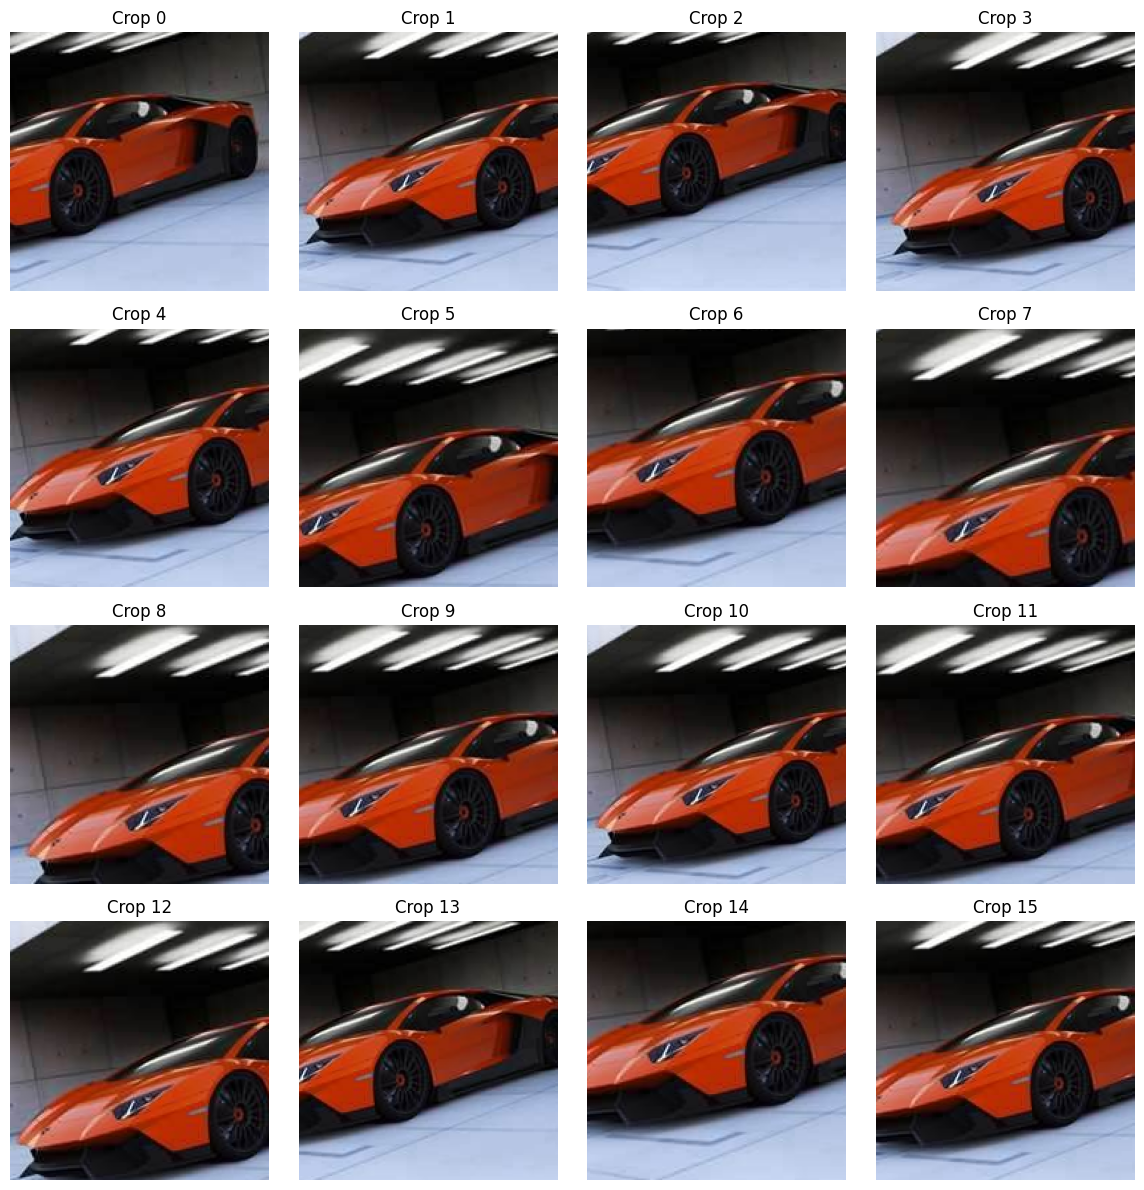

In [54]:
# Visualize the crops
plt.figure(figsize=(12, 12))
for i, crop in enumerate(crops):
    plt.subplot(4, 4, i + 1)
    plt.imshow(crop)
    plt.title(f"Crop {i}")
    plt.axis("off")
    plt.tight_layout()
    if i == 15: break

In [54]:
top_k_labels = torch.topk(pseudo_logits, k=100, dim=-1).indices.flatten()
print({classnames[label.item()]: pseudo_logits[0, label].item() for label in top_k_labels})

{'Lamborghini Aventador Coupe 2012': 0.33562102913856506, 'Lamborghini Gallardo LP 570-4 Superleggera 2012': 0.3295551538467407, 'Lamborghini Reventon Coupe 2008': 0.2971791625022888, 'McLaren MP4-12C Coupe 2012': 0.2796434462070465, 'Lamborghini Diablo Coupe 2001': 0.2601070702075958, 'Chevrolet HHR SS 2010': 0.24288134276866913, 'Audi R8 Coupe 2012': 0.24209624528884888, 'Ferrari 458 Italia Coupe 2012': 0.24085599184036255, 'Ford GT Coupe 2006': 0.23992452025413513, 'Ferrari 458 Italia Convertible 2012': 0.23902571201324463, 'Ford Fiesta Sedan 2012': 0.2181321680545807, 'Chevrolet Corvette ZR1 2012': 0.2065247744321823, 'Bugatti Veyron 16.4 Convertible 2009': 0.2058018445968628, 'Aston Martin V8 Vantage Coupe 2012': 0.2055370807647705, 'Bugatti Veyron 16.4 Coupe 2009': 0.2045164704322815, 'Aston Martin V8 Vantage Convertible 2012': 0.20116876065731049, 'Land Rover LR2 SUV 2012': 0.1983267068862915, 'Chevrolet Corvette Convertible 2012': 0.196316197514534, 'Plymouth Neon Coupe 1999': 

In [55]:
cls_desc_emb = all_desc_embeds[pseudo_labels] # (batch_size, num_descriptions, embed_dim)
_crop_feats = crop_weights.unsqueeze(-1) * crop_feats
crop_desc_sim = _crop_feats @ cls_desc_emb.transpose(1, 2) # (batch_size, num_crops, num_descriptions)

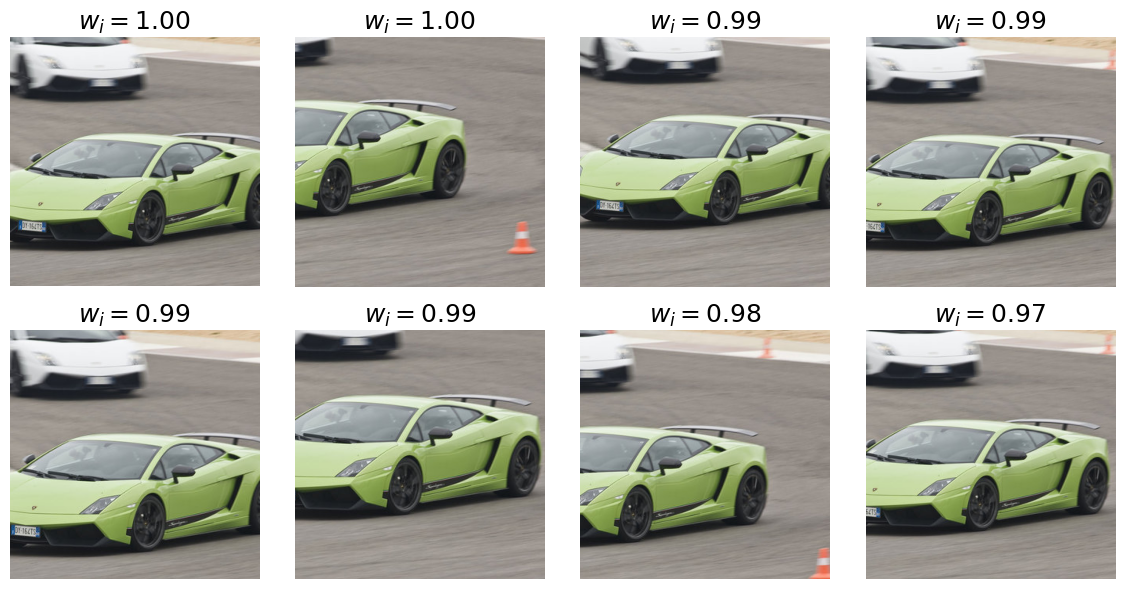

In [56]:
# Visualize the selected crops
plt.figure(figsize=(12, 6))
ids = sorted(top_k_indices.flatten().tolist())
top_k_crops = [crops[i] for i in ids]
for i, crop in enumerate(top_k_crops):
    plt.subplot(2, 4, i + 1)
    plt.imshow(crop)
    plt.title(r"$w_i=$" + f"{crop_weights[0, i].item():.2f}", fontsize=18)
    plt.axis("off")
    plt.tight_layout()
    plt.savefig('output/crop_visual.pdf', bbox_inches='tight')

In [57]:
top_k_crop_descs = torch.topk(crop_desc_sim, k=3, dim=-1).indices.squeeze(0)
top_k_crop_texts = [[] for _ in range(8)]
for i, crop_descs in enumerate(top_k_crop_descs):
    for desc in crop_descs:
        top_k_crop_texts[i].append(model.all_texts[pseudo_labels.item()][desc.item()])

In [58]:
cls_desc_emb = all_desc_embeds[torch.tensor([label])] # (batch_size, num_descriptions, embed_dim)
_crop_feats = crop_weights.unsqueeze(-1) * crop_feats
crop_desc_sim = _crop_feats @ cls_desc_emb.transpose(1, 2) # (batch_size, num_crops, num_descriptions)

true_top_k_crop_descs = torch.topk(crop_desc_sim, k=3, dim=-1).indices.squeeze(0)
true_top_k_crop_texts = [[] for _ in range(8)]
for i, crop_descs in enumerate(true_top_k_crop_descs):
    for desc in crop_descs:
        true_top_k_crop_texts[i].append(model.all_texts[label][desc.item()])
        
for i in range(8):
    top_k_crop_texts[i] = (top_k_crop_texts[i], true_top_k_crop_texts[i])

In [59]:
top_k_crop_texts

[(['This is a photo of a Lamborghini Aventador Coupe from 2012.',
   'The Lamborghini Aventador Coupe 2012 is a type of car that looks like a small sports car.',
   'The Lamborghini Aventador Coupe 2012 can be identified by its distinctive style and performance.'],
  ['This is a photo of a Lamborghini Gallardo LP 570-4 Superleggera.',
   'The exterior of the Lamborghini Gallardo LP 570-4 Superleggera 2012 is characterized by its aggressive and sporty design.',
   'The Lamborghini Gallardo LP 570-4 Superleggera 2012 is a two-seater supercar that is equipped with a 5.']),
 (['This is a photo of a Lamborghini Aventador Coupe from 2012.',
   'The Lamborghini Aventador Coupe 2012 is a type of car that looks like a small sports car.',
   'The Lamborghini Aventador Coupe 2012 can be identified by its unique body style and design.'],
  ['This is a photo of a Lamborghini Gallardo LP 570-4 Superleggera.',
   ' Lamborghini Gallardo LP 570-4 Superleggera in action.',
   'The Lamborghini Gallardo L

## Other

In [ ]:
pl_diffs = []
other_diffs = []

for i, (inputs, true_labels) in tqdm(enumerate(data_loader_train)):
    with torch.no_grad():
        img_train_weak = inputs[:, 0].to(device, non_blocking=True)
        img_train_strong = inputs[:, 1].to(device, non_blocking=True)
        img_train_crops = inputs[:, 2:].to(device, non_blocking=True)
        
        feat_weak, cls_token =  model(img_train_weak, return_cls_token=True)
        
        crop_feats, crop_cls_token = model(img_train_crops.flatten(0, 1), return_cls_token=True)
        crop_feats = crop_feats.view(img_train_crops.shape[0], img_train_crops.shape[1], -1) # (batch_size, num_crops, embed_dim)
        crop_cls_token = crop_cls_token.view(img_train_crops.shape[0], img_train_crops.shape[1], -1) # (batch_size, num_crops, embed_dim)
        crop_weights = torch.einsum('bd,bcd->bc', cls_token, crop_cls_token)
        
        top_k_indices = torch.topk(crop_weights, k=args.n_crops, dim=-1).indices
        crop_feats = torch.gather(crop_feats, 1, top_k_indices.unsqueeze(-1).expand(-1, -1, crop_feats.shape[-1]))
        crop_weights = torch.gather(crop_weights, 1, top_k_indices)
        crop_weights /= crop_weights.max(dim=-1, keepdim=True).values
        
        pseudo_logits = WCA_evaluation_one_iter(all_desc_embeds, sum_desc_weights, crop_feats, crop_weights, image_scale=train_config['image_scale'])
        pseudo_labels = torch.argmax(pseudo_logits, -1)
        
        cls_desc_emb = all_desc_embeds[pseudo_labels]
        crop_feats = crop_weights.unsqueeze(-1) * crop_feats
        crop_proto_sim = crop_feats @ model.get_classifier().t()
        # crop_desc_sim = crop_feats @ cls_desc_emb.transpose(1, 2) # (batch_size, num_crops, num_descriptions)
        # max_desc_sim, _ = torch.max(crop_desc_sim, dim=-1)
        # # Score gaps better capture the uncertainty [CODER].
        # score_gaps = (max_desc_sim.unsqueeze(-1) - crop_desc_sim).sum(dim=-1)
        # pl_certainty = score_gaps.mean(dim=-1)
        pl_diffs.extend(crop_proto_sim.cpu().flatten().numpy())
        
        # Exclude the pseudo-label from the set of descriptions
        other_protos = model.get_classifier().view(1, -1, model.get_classifier().size(-1)).expand(pseudo_labels.size(0), -1, -1)
        other_protos = torch.stack([torch.stack([other_protos[i] for i in range(other_protos.size(0)) if i != pseudo_labels[j]]) for j in range(pseudo_labels.size(0))])
        other_crop_proto_sim = crop_feats.unsqueeze(1) @ other_protos.transpose(2, 3)
        # other_descs = torch.stack([torch.stack([all_desc_embeds[i] for i in range(all_desc_embeds.size(0)) if i != pseudo_labels[j]]) for j in range(pseudo_labels.size(0))])
        # other_crop_desc_sim = crop_feats.unsqueeze(1) @ other_descs.transpose(2, 3) # (batch_size, num_crops, num_descriptions)
        # max_other_desc_sim, _ = torch.max(other_crop_desc_sim, dim=-1)
        # score_gaps_other = (max_other_desc_sim.unsqueeze(-1) - other_crop_desc_sim).sum(dim=-1)
        # other_certainty = score_gaps_other.mean(dim=-1)
        other_diffs.extend(other_crop_proto_sim.cpu().flatten().numpy())

Text(0.5, 1.0, 'Max Similarity to Description for the selected class')

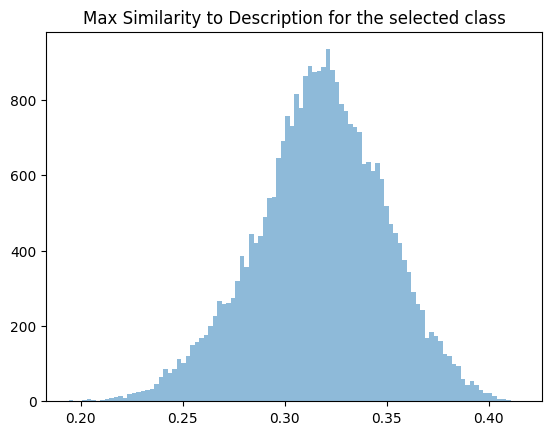

In [14]:
f = plt.hist(pl_diffs, bins=100, alpha=0.5, label='PL Certainty')
plt.title('Max Similarity to Description for the selected class')

Text(0.5, 1.0, 'Max Similarity to Description for other classes')

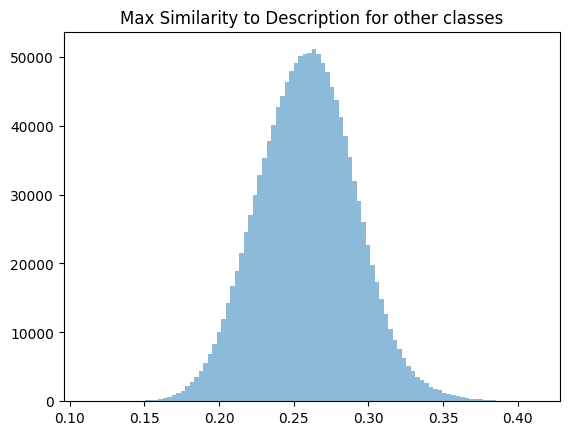

In [15]:
f = plt.hist(other_diffs, bins=100, alpha=0.5, label='Other Certainty')
plt.title('Max Similarity to Description for other classes')